# Predicting Malignant Melanoma by Appearance

Tutorial by Sankha Ghosal, Jacob Keller and Madhur Maheshwari

## Why melanoma?



 Malignant melanoma is a serious health risk, a cancer of the skin most commonly caused by chronic overexposure to the sun. Like any cancer, melanoma can metastasize and attack the entire body, potentially fatally, if not identified and addressed early in its cycle. And yet, most people think of sunburns as minor annoyances, like papercuts, not giving this serious risk the attention it deserves. Given that members of our families have suffered from this disease, we decided that designing deep learning model to rapidly identify and diagnose melanoma could greatly improve health outcomes for young Americans and for people worldwide.

 In addition to its personal and medical relevance, malignant melanoma also presents an intriguing challenge as we construct our model, because it is often difficult to distinguish visually from freckles, moles, or even benign melanoma. To ensure the validity of our model in this difficult task, we have chosen a dataset that includes a training set of 4605 malignant melanoma images and 5000 benign melanoma images, plus a test set of 500 malignant melanoma images and 500 benign melanoma images.

 **Source**

 Muhammad Hasnain Javid. (2022). Melanoma Skin Cancer Dataset of 10000 Images [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/3376422



# Gathering and Exploring Our Data
Thanks to the International Skin Imaging Collaboration (ISIC) project, hundreds of thousands of images of melanoma are available on the Internet, all labeled by type and malignance. We chose to analyze [this dataset from Kaggle](https://https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/datahttps://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data) because it contains a large number of images, binarily classified as benign or malignant, and lacking any other patient data. This will enable us to train our model to rapidly identify melanoma based just on its appearance, without requiring us to gather any additional medical data.

The images in this dataset are of the JPEG file type. In the future, we plan to extend our model to handle other image types as well, particularly DICOM files, a file type commonly used in medical imaging for its ability to store images alongside patient information and imaging metadata. The additional information stored in these DICOM files could make our model even more impactful and useful for medical professionals.

## Data Import and Resizing
Below, we begin by mounting our Google Drive, so that we can access our dataset (uploaded there as a .zip file):

In [ ]:
# Mount our Google Drive to our Colab workspace. This is the first step of making our data accessible within our notebook.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


As a next step, we need to import the libraries we'll be using for this project, along with our data itself.

In [ ]:
# Install and import necessary libraries
!pip install torch torchvision torchaudio wandb timm opencv-python
!pip install timm

import os
import zipfile
import wandb
import torch
import torch.nn
import timm
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from zipfile import ZipFile
from pathlib import PurePosixPath
import io
import random
import pickle
from PIL import Image, ImageStat, ImageEnhance
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import cv2
from scipy.stats import chisquare, ttest_ind, shapiro, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import os
import zipfile
import pickle
import shutil
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

Since most machine learning models prefer or require images of an equal, standard size, we will clean our data by resizing all our images to the standard 256x256 during import.

You may also consider enhancing image quality at this stage, as we did at an earlier stage of building our model. However, after several iterations we believe that leaving images as is, given that our data are high-grade medical images, will actually allow our model to learn and generalize to new images better.

In [ ]:
# Define the path to our full dataset
full_dataset_path = "/content/drive/MyDrive/DATA602_Final_Project/full_dataset.zip"

# Define path to our future resized training set
resized_train_dir = "/content/drive/MyDrive/DATA602_Final_Project/train_resized.zip"

# Define the path to our future resized test set
resized_test_dir = "/content/drive/MyDrive/DATA602_Final_Project/test_resized.zip"

# Open full dataset as read-only for resizing
with ZipFile(full_dataset_path, 'r') as dataset:

  # Split dataset into train and test based on file label
  train_files = [f for f in dataset.namelist() if '/train/' in f and f.lower().endswith('.jpg')]
  test_files  = [f for f in dataset.namelist() if '/test/'  in f and f.lower().endswith('.jpg')]

  # Open resized train set path as write-only
  with ZipFile(resized_train_dir, 'w') as resized_train:

    # Iterate over all files in train set
    for file_name in train_files:

      # Read image in file location
      try:
        img_data = dataset.read(file_name)
        img = Image.open(io.BytesIO(img_data))

        # Resize image to (256, 256) for optimal machine learning
        img_resized = img.resize((256, 256), Image.LANCZOS)

        # Extract relative path
        parts = PurePosixPath(file_name).parts
        train_index = parts.index("train")
        relative_path = "/".join(parts[train_index+1:])

        # Save enhanced and resized image
        buf = io.BytesIO()
        img_resized.save(buf, format=img.format or "JPEG")
        resized_train.writestr(relative_path, buf.getvalue())

      # Handle any processing errors
      except Exception as e:

        # Output error message
        print(f"Error processing {file_name}: {e}")
        continue

  # Open resized test set path as write-only
  with ZipFile(resized_test_dir, 'w') as resized_test:

    # Iterate over all files in test set
    for file_name in test_files:

      # Read image in file location
      try:
        img_data = dataset.read(file_name)
        img = Image.open(io.BytesIO(img_data))

        # Resize image to (256, 256) for optimal machine learning processing
        img_resized = img.resize((256, 256), Image.LANCZOS)

        # Extract parts of path to individual image file
        parts = PurePosixPath(file_name).parts

        # Find test folder in individual image path
        test_index = parts.index("test")

        # Skip every part of individual image path before "test"
        relative_path = "/".join(parts[test_index+1:])

        # Save resized image
        buf = io.BytesIO()
        img_resized.save(buf, format=img.format or "JPEG")

        # Write cleaned image to cleaned train folder
        resized_test.writestr(relative_path, buf.getvalue())

      # Handle any processing errors
      except Exception as e:

        # Output error message
        print(f"Error processing {file_name}: {e}")
        continue

To verify our success in the above tasks, we'll now print the classes present in our "train" and "test" sets.

Based on what we know about our dataset, these should be "benign" and "malignant" for both the train and test sets.

In [ ]:
  # Define a list of classes, based on the classes in our train set
  classes_train = sorted(set(
    PurePosixPath(f).parts[PurePosixPath(f).parts.index("train")+1]
    for f in train_files
    if "train" in PurePosixPath(f).parts
  ))

  # Define a list of classes, based on the classes in our test set
  classes_test = sorted(set(
    PurePosixPath(f).parts[PurePosixPath(f).parts.index("test")+1]
    for f in test_files
    if "test" in PurePosixPath(f).parts
  ))

# Notify user of detected classes in train & test sets
print("\nDetected train classes:", classes_train)
print("\nDetected test classes:", classes_test)


Detected train classes: ['benign', 'malignant']

Detected test classes: ['benign', 'malignant']


## DataFrame Building and Exploration
The next step is to explore our data in order to fully understand it. We'll begin by extracting the key features of our image data into a pandas DataFrame for easy analysis.

In [ ]:
# Define a function that will load our images into a DataFrame for easy analysis
def image_df(zip_path, classes, limit=None):

  # Initialize an empty list we will fill with our data
  data=[]

  # Open zipfile of our image data
  with zipfile.ZipFile(zip_path, 'r') as database:

    # List all filenames in .zip
    file_list = database.namelist()

    # Iterate over all classes in our dataset
    for cls in classes:

      # Filter so we only see images in current class
      class_images = [file for file in file_list if file.startswith(cls + '/')]

      # Remove images beyond max number specified (if passed)
      if limit:
        class_images = class_images[:limit]

      # Iterate over all images in current class
      for image_path in class_images:

        # Read image data directly from file
        try:
          with database.open(image_path) as file:

            # Read image
            image = Image.open(io.BytesIO(file.read()))

            # Ensure image is RGB color format
            image = image.convert("RGB")

          # Read image size
          width, height = image.size

          # Calculate average intensity of each color channel
          stat = ImageStat.Stat(image)
          red_mean, green_mean, blue_mean = stat.mean

          # Calculate standard deviation of each color channel
          red_std, green_std, blue_std = stat.stddev

          # Convert image to grayscale to analyze intensity
          gray = image.convert('L')

          # Calculate image intensity
          gray_np = np.array(gray, dtype=np.uint8)
          laplacian = cv2.Laplacian(gray_np, cv2.CV_64F)
          sharpness = laplacian.var()

          # Add data we've extracted to our list
          data.append({
              "Filename": image_path.split('/')[-1],
              "Class": cls,
              "Width": width,
              "Height": height,
              "Blue_mean": blue_mean,
              "Green_mean": green_mean,
              "Red_mean": red_mean,
              "Blue_std": blue_std,
              "Green_std": green_std,
              "Red_std": red_std,
              "Sharpness": sharpness
              })

          # Handle any unexpected file errors
        except Exception as e:
          print(f"Unexpected error with {image_path}: {e}")
          continue

  # Return image DataFrame
  return pd.DataFrame(data)

resized_train_dir = "/content/drive/MyDrive/DATA602_Final_Project/train_resized.zip"
resized_test_dir = "/content/drive/MyDrive/DATA602_Final_Project/test_resized.zip"

# Create DataFrame of training images
df_train = image_df(resized_train_dir, classes_train, limit=None)

# Create DataFrame of test images
df_test = image_df(resized_test_dir, classes_test, limit=None)

Now, for a sanity check, we'll print the first five lines of our dataframes, their summary statistics and other key column information, as well as a random sample of the images in both sets. This will allow us to examine our data, its types, and the missing value counts of each feature, as well as assess the central tendency and spread of our numerical data.

In [ ]:
# Define a function that will display some of the sample images
def display_sample_images(zip_path, df, sample_size=5):

    # Randomly sample a few images
    sample_df = df.sample(sample_size, random_state=42)

    # Open the zip file to read the image data
    with zipfile.ZipFile(zip_path, 'r') as database:
        plt.figure(figsize=(15, 5))

        for i, row in enumerate(sample_df.itertuples(), 1):
            image_path = f"{row.Class}/{row.Filename}"

            try:
                # Read the image and show it
                with database.open(image_path) as file:
                    image = Image.open(io.BytesIO(file.read()))
                    image = image.convert("RGB")

                # Plot the image
                plt.subplot(1, sample_size, i)
                plt.imshow(image)
                plt.axis("off")
                plt.title(f"Class: {row.Class}\n({row.Filename})", fontsize=9)

            except Exception as e:
                print(f"Could not load {image_path}: {e}")
                continue

        plt.tight_layout()
        plt.show()

# Print size of train and test datasets
print(f"Train Dataset Size: {len(df_train)}")
print(f"\nTest Dataset Size: {len(df_test)}")

# Print preview of train and test datasets
print("\nTrain Dataset Preview: \n", df_train.head())
print("\nTest Dataset Preview: \n", df_test.head())

Train Dataset Size: 9605

Test Dataset Size: 1000

Train Dataset Preview: 
             Filename   Class  Width  Height   Blue_mean  Green_mean  \
0     melanoma_0.jpg  benign    256     256  199.485367  203.990738   
1     melanoma_1.jpg  benign    256     256  185.211121  195.162567   
2    melanoma_10.jpg  benign    256     256  178.852386  176.928574   
3   melanoma_100.jpg  benign    256     256  201.164017  195.680069   
4  melanoma_1000.jpg  benign    256     256  122.928284  127.036591   

     Red_mean   Blue_std  Green_std    Red_std   Sharpness  
0  242.673523  22.331822  15.909801  13.110996   42.487120  
1  239.156235  19.644778  16.621198  15.767713  215.245001  
2  227.864975  31.898888  24.282133  20.175481  371.665336  
3  241.964966  16.805410  15.906786  14.864253   31.183485  
4  165.470535  38.843133  38.359877  38.876573   37.963984  

Test Dataset Preview: 
              Filename   Class  Width  Height   Blue_mean  Green_mean  \
0  melanoma_10000.jpg  benign    2

In [ ]:
# Print train data info
print(f"\nTrain DataFrame Info: \n")
df_train.info()

# Print test data info
print(f"\nTest DataFrame Info: \n")
df_test.info()


Train DataFrame Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9605 entries, 0 to 9604
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Filename    9605 non-null   object 
 1   Class       9605 non-null   object 
 2   Width       9605 non-null   int64  
 3   Height      9605 non-null   int64  
 4   Blue_mean   9605 non-null   float64
 5   Green_mean  9605 non-null   float64
 6   Red_mean    9605 non-null   float64
 7   Blue_std    9605 non-null   float64
 8   Green_std   9605 non-null   float64
 9   Red_std     9605 non-null   float64
 10  Sharpness   9605 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 825.6+ KB

Test DataFrame Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Filename    1000 non-null   object 
 1   Class       1

In [ ]:
# Print train data summary statistics
print(f"\nTrain Data Summary Stats: \n{df_train.describe()} \n")

# Print test data summary statistics
print(f"\nTest Data Summary Stats: \n{df_test.describe()} \n")


Train Data Summary Stats: 
        Width  Height    Blue_mean   Green_mean     Red_mean     Blue_std  \
count  9605.0  9605.0  9605.000000  9605.000000  9605.000000  9605.000000   
mean    256.0   256.0   139.163977   144.752983   183.043869    36.920379   
std       0.0     0.0    40.011337    37.080680    41.598023    18.569259   
min     256.0   256.0     4.643234    18.050079    32.185028     6.553150   
25%     256.0   256.0   112.306396   121.357758   160.332260    22.892501   
50%     256.0   256.0   138.573486   144.278076   185.482925    31.320780   
75%     256.0   256.0   167.877945   173.222168   216.419540    46.829141   
max     256.0   256.0   243.250122   241.259064   251.234024   101.917013   

         Green_std      Red_std    Sharpness  
count  9605.000000  9605.000000  9605.000000  
mean     34.195921    31.451243   175.610364  
std      18.999948    21.977869   388.619777  
min       6.829028     4.863052     3.854461  
25%      19.638917    16.205155    29.94811


Train Data Class Counts: 
Class
benign       5000
malignant    4605
Name: count, dtype: int64 


Test Data Class Counts: 
Class
benign       500
malignant    500
Name: count, dtype: int64 

Sample Training Images:


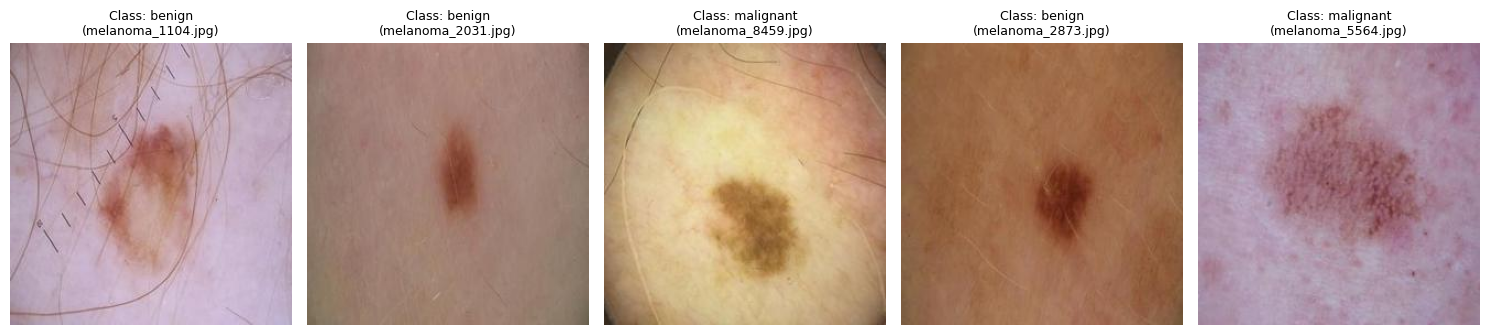

Sample Test Images:


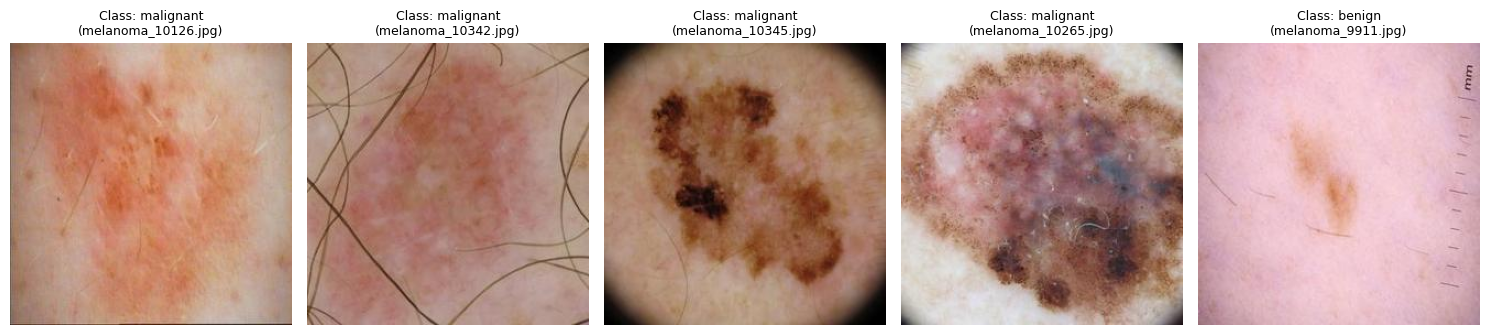

In [ ]:
# Print count of classes in train set
print(f"\nTrain Data Class Counts: \n{df_train['Class'].value_counts()} \n")

# Print count of classes in test set
print(f"\nTest Data Class Counts: \n{df_test['Class'].value_counts()} \n")

# Print sample images of classes in train set
print("Sample Training Images:")
display_sample_images(resized_train_dir, df_train, sample_size=5)

# Print sample images of classes in test set
print("Sample Test Images:")
display_sample_images(resized_test_dir, df_test, sample_size=5)

## Handling Duplicates and Missing Values
We can see from the sanity check above that our data does not contain any missing values. However, it's important to include steps to deal with these missing values in our workflow, to ensure our methods are generalizable to any dataset future users may pass to it.

Below we'll assess the duplicates and missing values in our dataset.

In [ ]:
# Print duplicate rows from training set
print("Duplicates in training set:\n", df_train[df_train.duplicated()])

# Print duplicate rows from test set
print("\nDuplicates in test set:\n", df_test[df_test.duplicated()])

# Print count of missing values in train set
train_df_missing = df_train.isnull().sum()
print("\nCount of missing values in training set:\n", train_df_missing)

# Print count of missing values in test set
test_df_missing = df_test.isnull().sum()
print("\nCount of missing values in test set:\n", test_df_missing)

Duplicates in training set:
 Empty DataFrame
Columns: [Filename, Class, Width, Height, Blue_mean, Green_mean, Red_mean, Blue_std, Green_std, Red_std, Sharpness]
Index: []

Duplicates in test set:
 Empty DataFrame
Columns: [Filename, Class, Width, Height, Blue_mean, Green_mean, Red_mean, Blue_std, Green_std, Red_std, Sharpness]
Index: []

Count of missing values in training set:
 Filename      0
Class         0
Width         0
Height        0
Blue_mean     0
Green_mean    0
Red_mean      0
Blue_std      0
Green_std     0
Red_std       0
Sharpness     0
dtype: int64

Count of missing values in test set:
 Filename      0
Class         0
Width         0
Height        0
Blue_mean     0
Green_mean    0
Red_mean      0
Blue_std      0
Green_std     0
Red_std       0
Sharpness     0
dtype: int64


This confirms that our data has no duplicates or missing values. Phew! Although we avoided it this time, it's theoretically possible for our data to include duplicates or even missing values. Therefore, for generalizability's sake, we'll include some steps below to remove duplicates and/or missing values, since they could bias our model's predictions.

In [ ]:
# Drop rows with missing values from both our train and test set
df_train = df_train.dropna()
df_test = df_test.dropna()

# Drop duplicate rows from both our train and test set
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

# Print duplicate rows from training set
print("Duplicates in training set (after cleaning):\n", df_train[df_train.duplicated()])

# Print duplicate rows from test set
print("\nDuplicates in test set (after cleaning):\n", df_test[df_test.duplicated()])

# Print count of missing values in train set
train_df_missing = df_train.isnull().sum()
print("\nCount of missing values in training set (after cleaning):\n", train_df_missing)

# Print count of missing values in test set
test_df_missing = df_test.isnull().sum()
print("\nCount of missing values in test set (after cleaning):\n", test_df_missing)

Duplicates in training set (after cleaning):
 Empty DataFrame
Columns: [Filename, Class, Width, Height, Blue_mean, Green_mean, Red_mean, Blue_std, Green_std, Red_std, Sharpness]
Index: []

Duplicates in test set (after cleaning):
 Empty DataFrame
Columns: [Filename, Class, Width, Height, Blue_mean, Green_mean, Red_mean, Blue_std, Green_std, Red_std, Sharpness]
Index: []

Count of missing values in training set (after cleaning):
 Filename      0
Class         0
Width         0
Height        0
Blue_mean     0
Green_mean    0
Red_mean      0
Blue_std      0
Green_std     0
Red_std       0
Sharpness     0
dtype: int64

Count of missing values in test set (after cleaning):
 Filename      0
Class         0
Width         0
Height        0
Blue_mean     0
Green_mean    0
Red_mean      0
Blue_std      0
Green_std     0
Red_std       0
Sharpness     0
dtype: int64


## Visualization & Exploratory Analysis

Visualizing our data in various ways can often help us understand the unique characteristics of our data, most crucially how it is distributed and interrelated. Performing any statistically valid analysis requires that we understand these characteristics first, to avoid statistical errors or invalid conclusions.

### Hypothesis 1: Color-Class Relationship

Below, we construct a boxplot and a histogram to visualize how colors vary between our benign and malignant images. We also perform some quick statistical tests to check whether the differences in color values between benign and malignant images are statistically significant (i.e., if the difference(s) are unlikely to be due to random variation).

In each of these tests, our **Null Hypothesis** is that there is no significant difference in average color value between the benign and malignant groups. Conversely, our **Alternative Hypothesis** is that there *is* a significant difference in average color value between the benign and malignant groups.

Finally, we create a scatter plot comparing color values to image sharpness, to evaluate whether this may be a confounding variable in the relationship between color value and benign/malignant nature of melanoma.

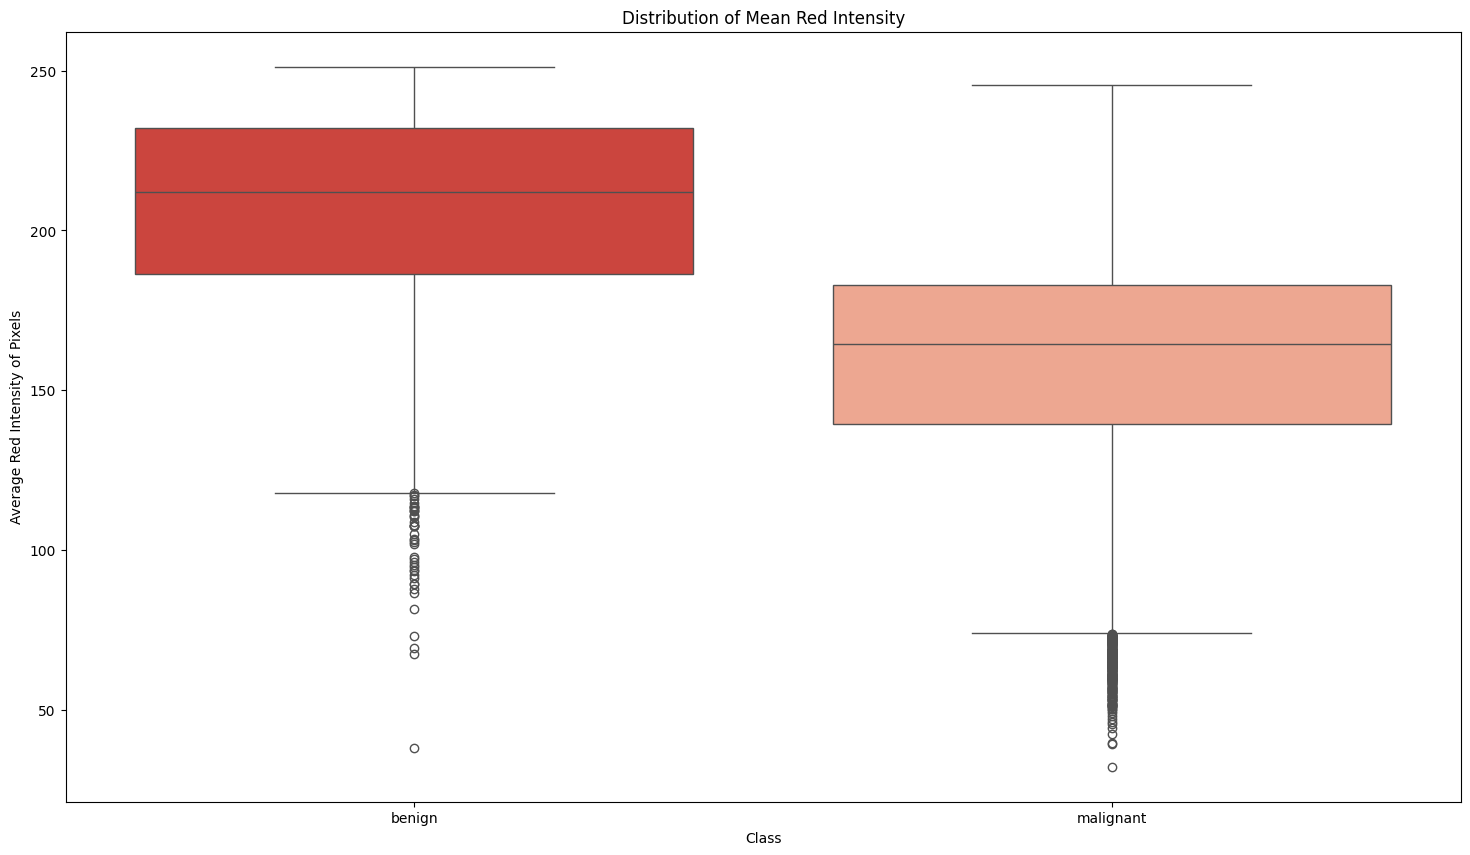

In [ ]:
# Combine both datasets (train and test) for visualization & exploratory analysis
full_df = pd.concat([df_train, df_test], axis = 0)

# Create figure on which to plot & compare mean color data
plt.figure(figsize=(18,10))

# Build boxplot to compare color means by class
sns.boxplot(data = full_df, x = 'Class', y = 'Red_mean', hue = 'Class', palette='Reds_r')

# Set plot title and labels
plt.title('Distribution of Mean Red Intensity')
plt.ylabel('Average Red Intensity of Pixels')
plt.xlabel('Class')

# Reveal plot
plt.show()

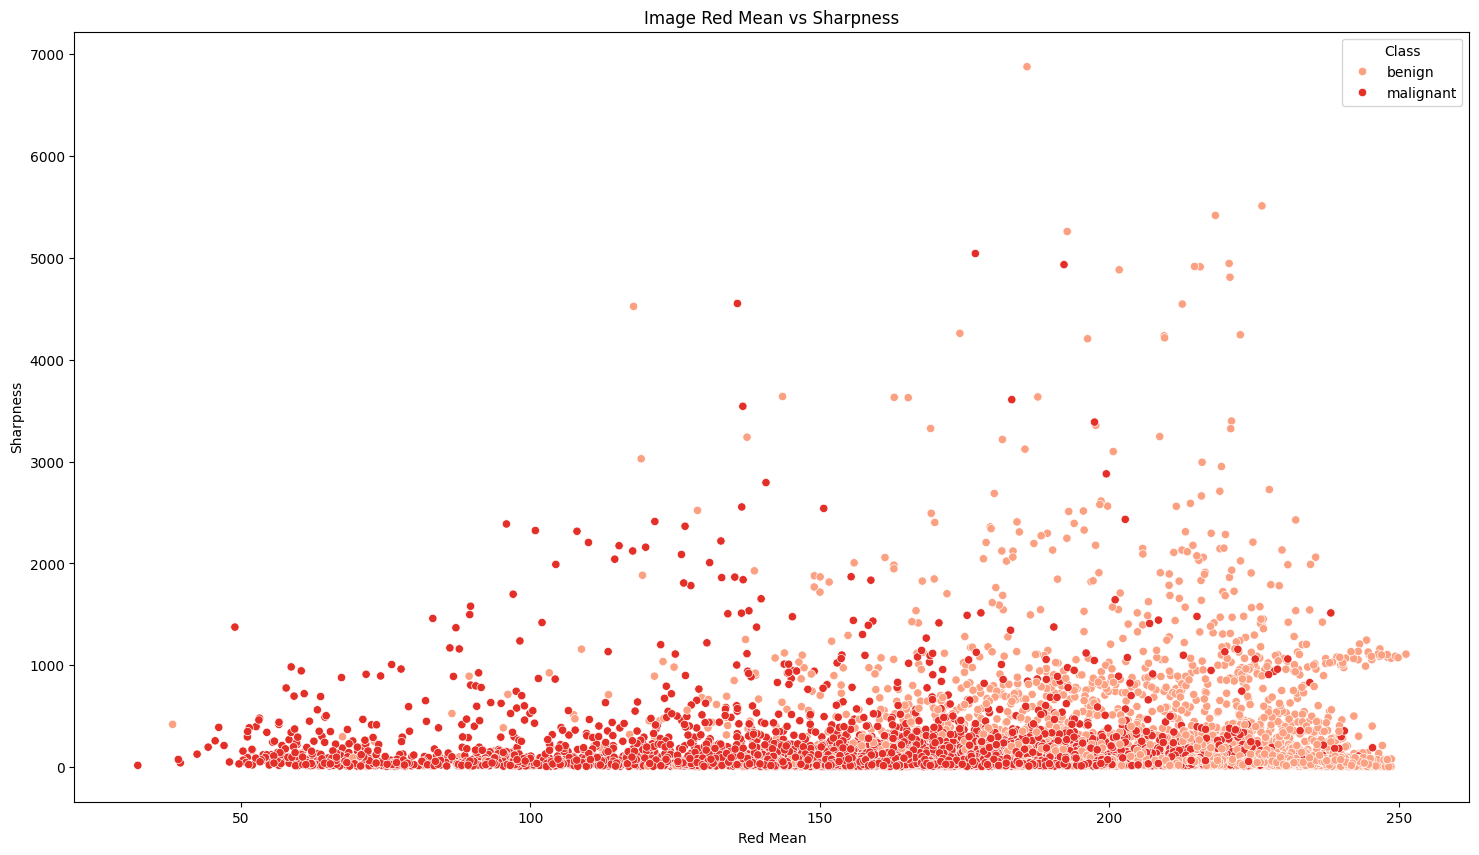


Test statistic: 61.118310327229736

P-value: 0.0

Red mean difference statistically significant!



In [ ]:
# Create figure on which to plot color mean against sharpness
plt.figure(figsize=(18,10))

# Build scatterplot of color mean vs sharpness
sns.scatterplot(data=full_df, x='Red_mean', y='Sharpness', hue = 'Class', palette = 'Reds')

# Set plot title and labels
plt.title('Image Red Mean vs Sharpness')
plt.xlabel('Red Mean')
plt.ylabel('Sharpness')

# Reveal plot
plt.show()

# Perform t-test of color means between train benign and train malignant
t_stat, p_val = ttest_ind(full_df.loc[df_train['Class'] == 'benign', f'Red_mean'], \
                                                     full_df.loc[df_train['Class'] == 'malignant', f'Red_mean'])

# Print results of t-test
print(f"\nTest statistic: {t_stat}\n")
print(f"P-value: {p_val}\n")

# Print "difference statistically significant!" if p-value less than alpha (0.05)
if p_val < 0.05:
  print("Red mean difference statistically significant!\n")

# Print "difference not statistically significant" if p-value greater than alpha (0.05)
else:
  print("Red mean difference not statistically significant.\n")

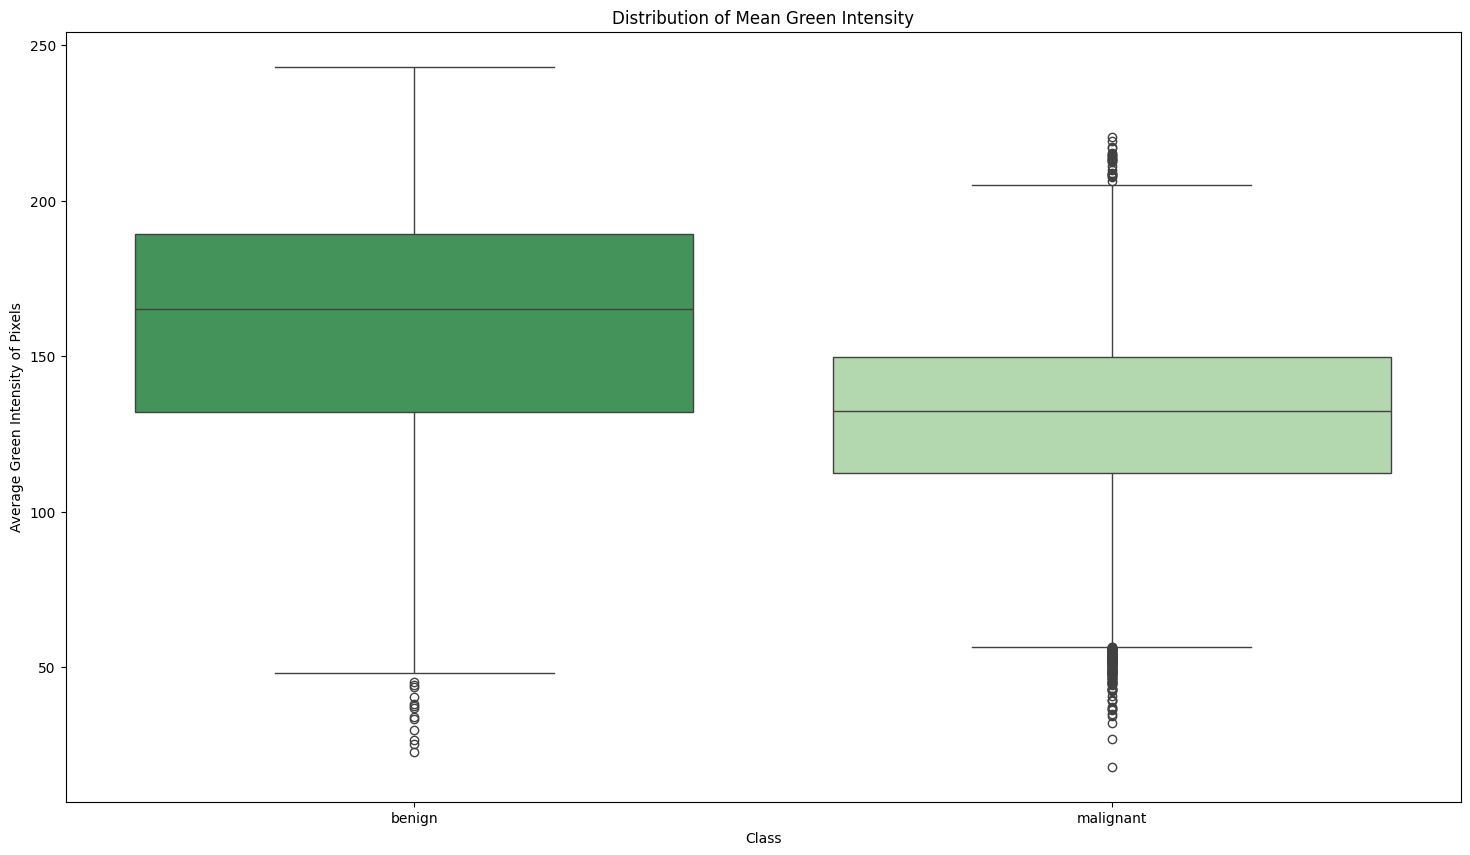

In [ ]:
# Create figure on which to plot & compare mean color data
plt.figure(figsize=(18,10))

# Build boxplot to compare color means by class
sns.boxplot(data = full_df, x = 'Class', y = 'Green_mean', hue = 'Class', palette='Greens_r')

# Set plot title and labels
plt.title('Distribution of Mean Green Intensity')
plt.ylabel('Average Green Intensity of Pixels')
plt.xlabel('Class')

# Reveal plot
plt.show()

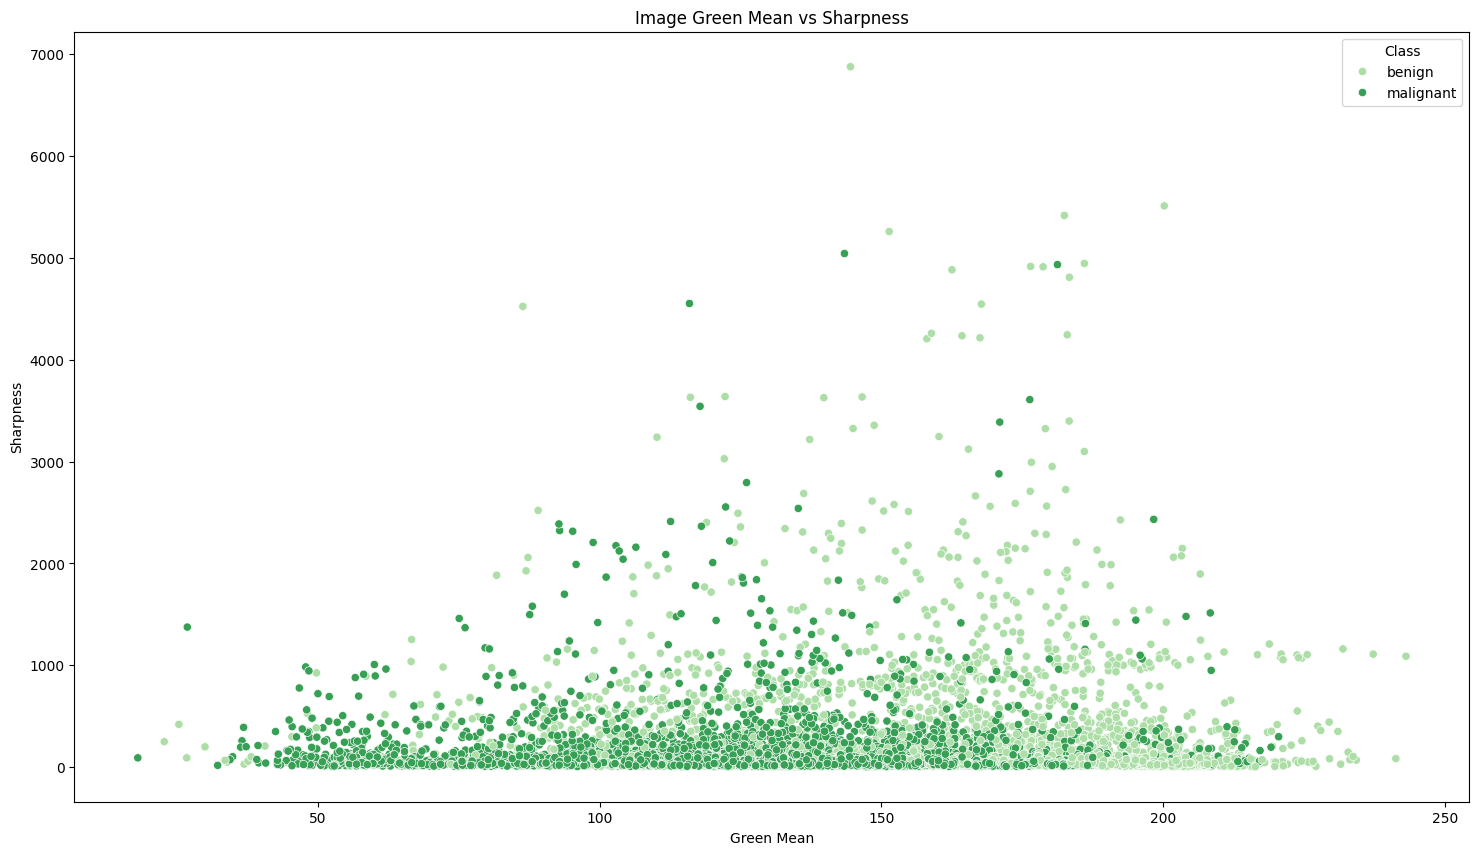


Test statistic: 39.10226305965332

P-value: 0.0

Green mean difference statistically significant!



In [ ]:
# Create figure on which to plot color mean against sharpness
plt.figure(figsize=(18,10))

# Build scatterplot of color mean vs sharpness
sns.scatterplot(data=full_df, x='Green_mean', y='Sharpness', hue = 'Class', palette = 'Greens')

# Set plot title and labels
plt.title('Image Green Mean vs Sharpness')
plt.xlabel('Green Mean')
plt.ylabel('Sharpness')

# Reveal plot
plt.show()

# Perform t-test of color means between train benign and train malignant
t_stat, p_val = ttest_ind(full_df.loc[df_train['Class'] == 'benign', 'Green_mean'], \
                                                     full_df.loc[df_train['Class'] == 'malignant', 'Green_mean'])

# Print results of t-test
print(f"\nTest statistic: {t_stat}\n")
print(f"P-value: {p_val}\n")

# Print "difference statistically significant!" if p-value less than alpha (0.05)
if p_val < 0.05:
  print("Green mean difference statistically significant!\n")

# Print "difference not statistically significant" if p-value greater than alpha (0.05)
else:
  print("Green mean difference not statistically significant.\n")

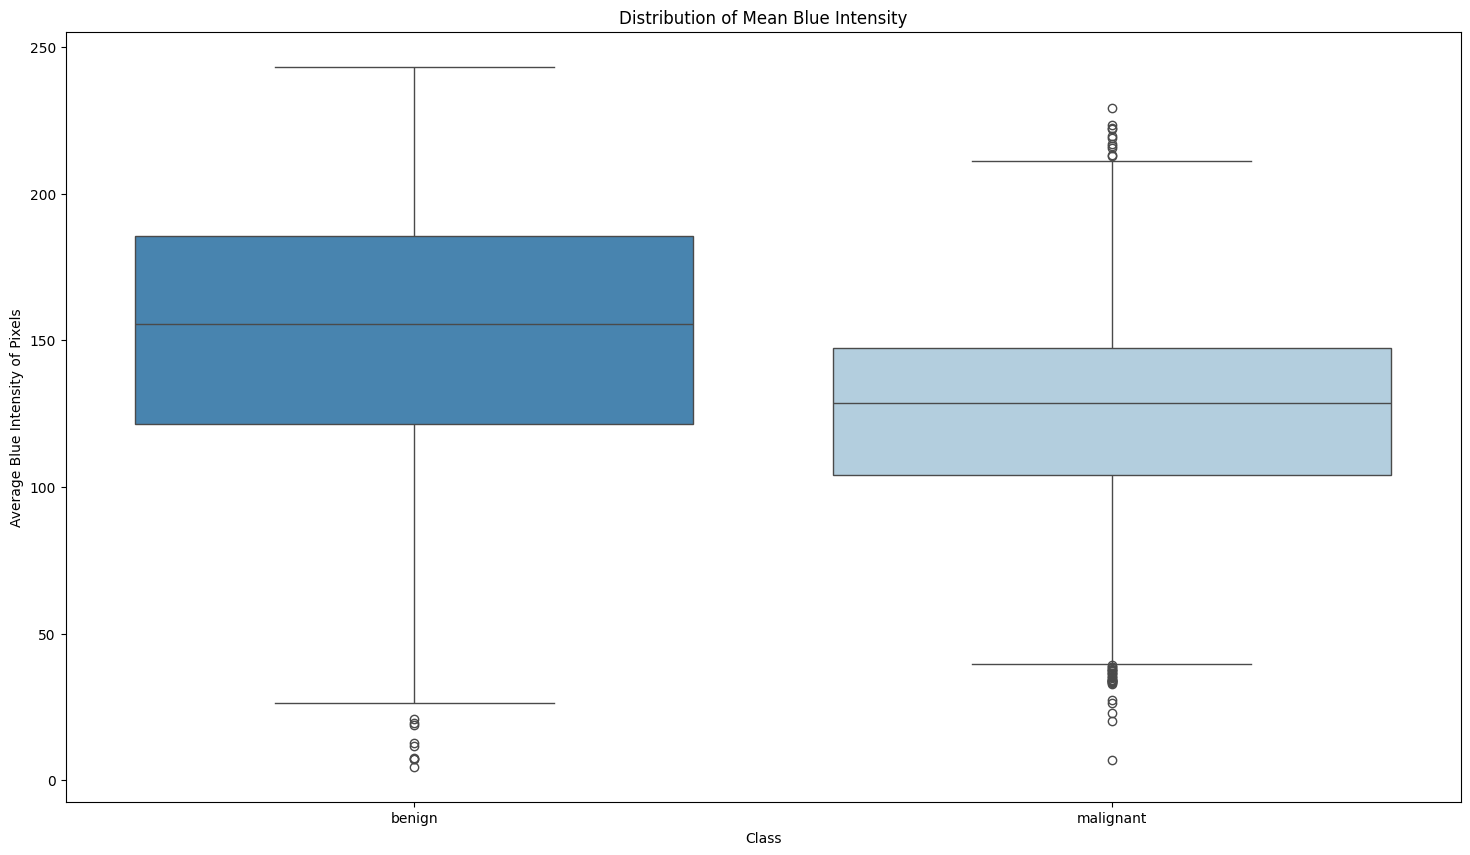

In [ ]:
# Create figure on which to plot & compare mean color data
plt.figure(figsize=(18,10))

# Build boxplot to compare color means by class
sns.boxplot(data = full_df, x = 'Class', y = 'Blue_mean', hue = 'Class', palette='Blues_r')

# Set plot title and labels
plt.title('Distribution of Mean Blue Intensity')
plt.ylabel('Average Blue Intensity of Pixels')
plt.xlabel('Class')

# Reveal plot
plt.show()

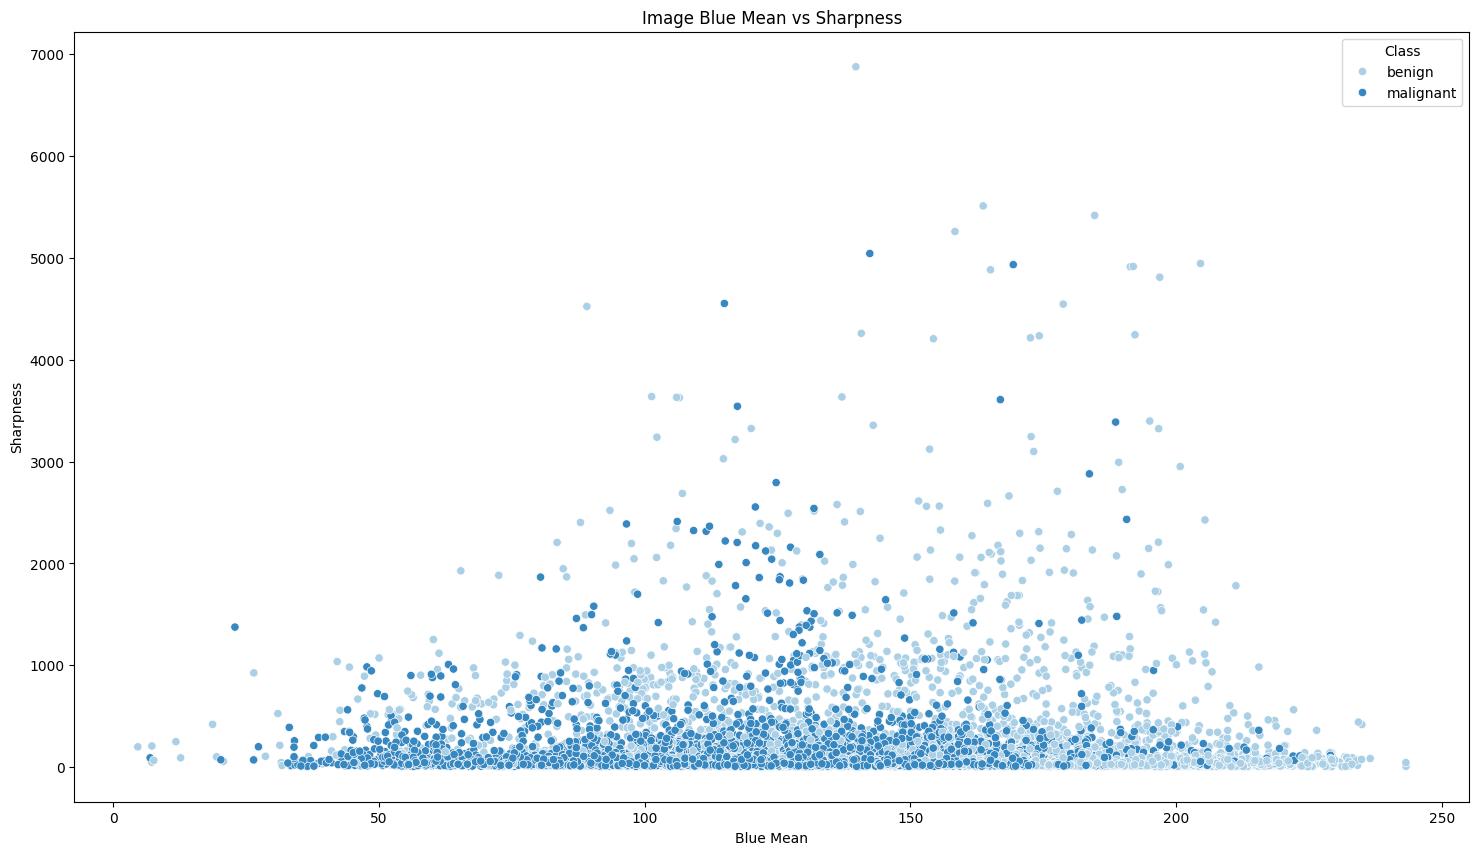


Test statistic: 31.19322451584223

P-value: 1.8973716174060774e-204

Blue mean difference statistically significant!



In [ ]:
# Create figure on which to plot color mean against sharpness
plt.figure(figsize=(18,10))

# Build scatterplot of color mean vs sharpness
sns.scatterplot(data=full_df, x='Blue_mean', y='Sharpness', hue = 'Class', palette = 'Blues')

# Set plot title and labels
plt.title('Image Blue Mean vs Sharpness')
plt.xlabel('Blue Mean')
plt.ylabel('Sharpness')

# Reveal plot
plt.show()

# Perform t-test of color means between train benign and train malignant
t_stat, p_val = ttest_ind(full_df.loc[df_train['Class'] == 'benign', 'Blue_mean'], \
                                                     full_df.loc[df_train['Class'] == 'malignant', 'Blue_mean'])

# Print results of t-test
print(f"\nTest statistic: {t_stat}\n")
print(f"P-value: {p_val}\n")

# Print "difference statistically significant!" if p-value less than alpha (0.05)
if p_val < 0.05:
  print("Blue mean difference statistically significant!\n")

# Print "difference not statistically significant" if p-value greater than alpha (0.05)
else:
  print("Blue mean difference not statistically significant.\n")

Fascinating! According to our hypothesis tests, there is a significant difference in average color value for *each color* between benign and malignant melanoma. Therefore, we can **reject our Null Hypothesis!**

Since our visualizations clearly show a higher mean value for each color in the benign group, it appears that each color may be negatively correlated with melanoma's malignancy. It also appears from our scatterplots that image sharpness does not correlate with any of the colors, meaning that quality of color capture likely does not affect the relationship between average color values and benign/malignant status. In other words, it would seem that the difference in color values between benign and malignant melanoma cannot be blamed on image quality.

We've now learned that color could be a powerful prediction factor for our machine learning model!

### Hypothesis 2: Intra-Color Correlation

Before we get too excited, it's also important to check the correlation between the three colors. Since we only performed pairwise comparisons between the benign and malignant groups for each color individually, it's possible that the color values are *correlated with each other*. If true, this would mean the two other colors are confounding the relationship we see between benignness and a given color.

Since we have already used a t-test in this checkpoint, below we'll create granular bins for each color value and perform a chi-square test instead.

Chi-square statistic: 0.0

P-value: 1.0

Degrees of Freedom: 0

Expected Frequencies: [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]

Color bins not statistically correlated.


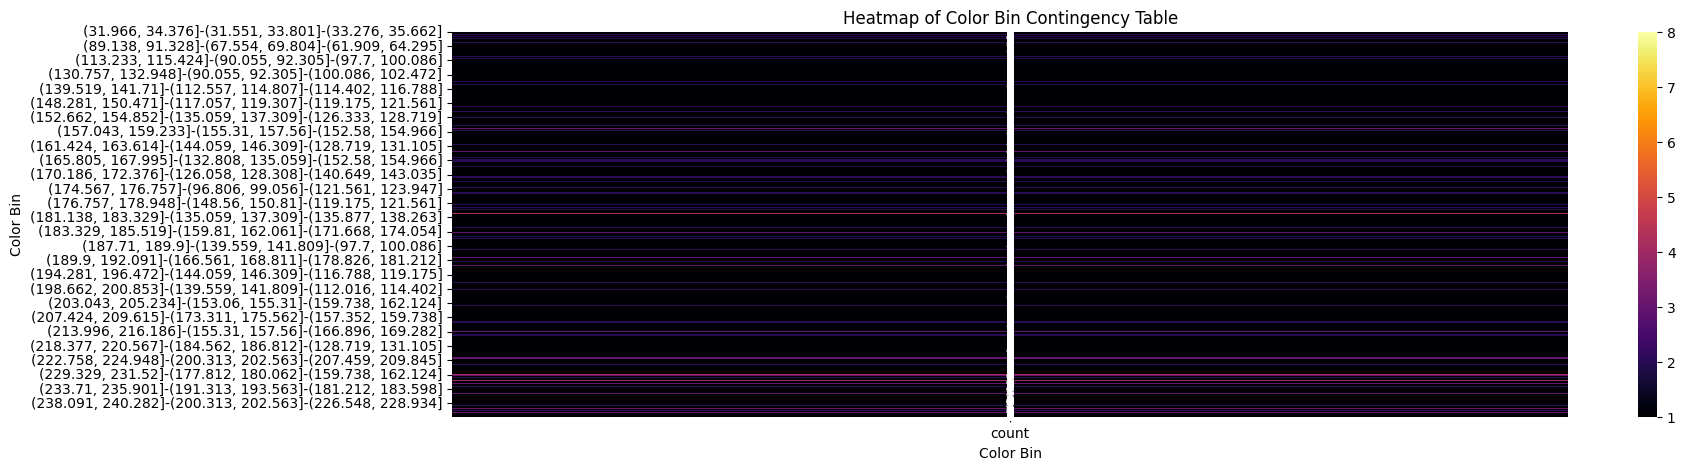

In [ ]:
# Create dataframe to hold granular color bins
bin_df = pd.DataFrame()

# Iterate over all three color channels
for color in ['Red', 'Green', 'Blue']:

  # Create bin series
  bin_df[f'{color}_bin'] = pd.cut(full_df[f'{color}_mean'], bins = 100)

# Create contingency table
contingency_table = pd.crosstab([bin_df['Red_bin'], bin_df['Green_bin'], bin_df['Blue_bin']], columns = 'count')

# Perform chi-square test and extract test statistics
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

# Print test statistics
print(f"Chi-square statistic: {chi2}")
print(f"\nP-value: {p_val}")
print(f"\nDegrees of Freedom: {dof}")
print(f"\nExpected Frequencies: {expected}")

# If p-value below our chosen alpha (0.05), notify user of significance
if p_val < 0.05:
  print("\nColor bins statistically correlated!")

# If p-value above our chosen alpha (0.05), notify user of insignificance
else:
  print("\nColor bins not statistically correlated.")

# Create figure on which to plot correlation matrix
plt.figure(figsize=(18,5))

# Plot correlation matrix of numeric features of full dataset as heatmap
sns.heatmap(contingency_table, annot = True, cmap = 'inferno')

# Set plot title and labels
plt.title('Heatmap of Color Bin Contingency Table')
plt.xlabel('Color Bin')
plt.ylabel('Color Bin')

# Reveal plot
plt.show()



Since the color values do not appear to be correlated, this indicates they are not *multicollinear*, validating our conclusion in test 1.

## Hypothesis 3: Color Equity between Train and Test

Based on our previous two tests, it appears that each color channel may be a powerful predictive feature for our machine learning model. However, a crucial assumption we must validate is that that this difference is not just a unique quirk of our train dataset. For this apparent correlation to be useful information, it must hold for the general population as well, which in this case is represented by our test set.

Below, we perform a One-Way Analysis of Variance (ANOVA) test to detect whether there is a significant difference in each of the color means between these four groups. If this is the case, the chances of this difference proving useful to our convolutional neural network grow even more likely.

In [ ]:
# Separate data by set and class
df_train_benign = df_train[df_train['Class'] == 'benign']
df_train_malignant = df_train[df_train['Class'] == 'malignant']
df_test_benign = df_test[df_test['Class'] == 'benign']
df_test_malignant = df_test[df_test['Class'] == 'malignant']

# Iterate over all three RGB channels
for color in ['Red', 'Green', 'Blue']:

  # Perform one-way ANOVA test
  t_stat, p_val = stats.f_oneway(df_train_benign[f'{color}_mean'], df_train_malignant[f'{color}_mean'], \
                                 df_test_benign[f'{color}_mean'], df_test_malignant[f'{color}_mean'])
  # Print test statistics
  print(f"\n{color} test statistic: {t_stat}")
  print(f"\n{color} p-value: {p_val}")

  # If p-value below our chosen alpha (0.05), notify user of statistical significance
  if p_val < 0.05:
    print(f"\n{color} difference statistically significant!")

  # If p-value above our chosen alpha (0.05), notify user of statistical insignificance
  else:
    print(f"\n{color} difference not statistically significant.")


Red test statistic: 1830.0061692283537

Red p-value: 0.0

Red difference statistically significant!

Green test statistic: 689.3463615360778

Green p-value: 0.0

Green difference statistically significant!

Blue test statistic: 465.4326322362371

Blue p-value: 4.140098571599196e-284

Blue difference statistically significant!


Fascinating again! We found a statistically significant difference in colors between the benign test, benign train, malignant test, and malignant train groups. This means we can **reject our null hypothesis**, and conclude that it is very unlikely that the difference in colorfulness in our groups is attributable to random variation.

For easier comparison, see the histograms of colorfulness below:

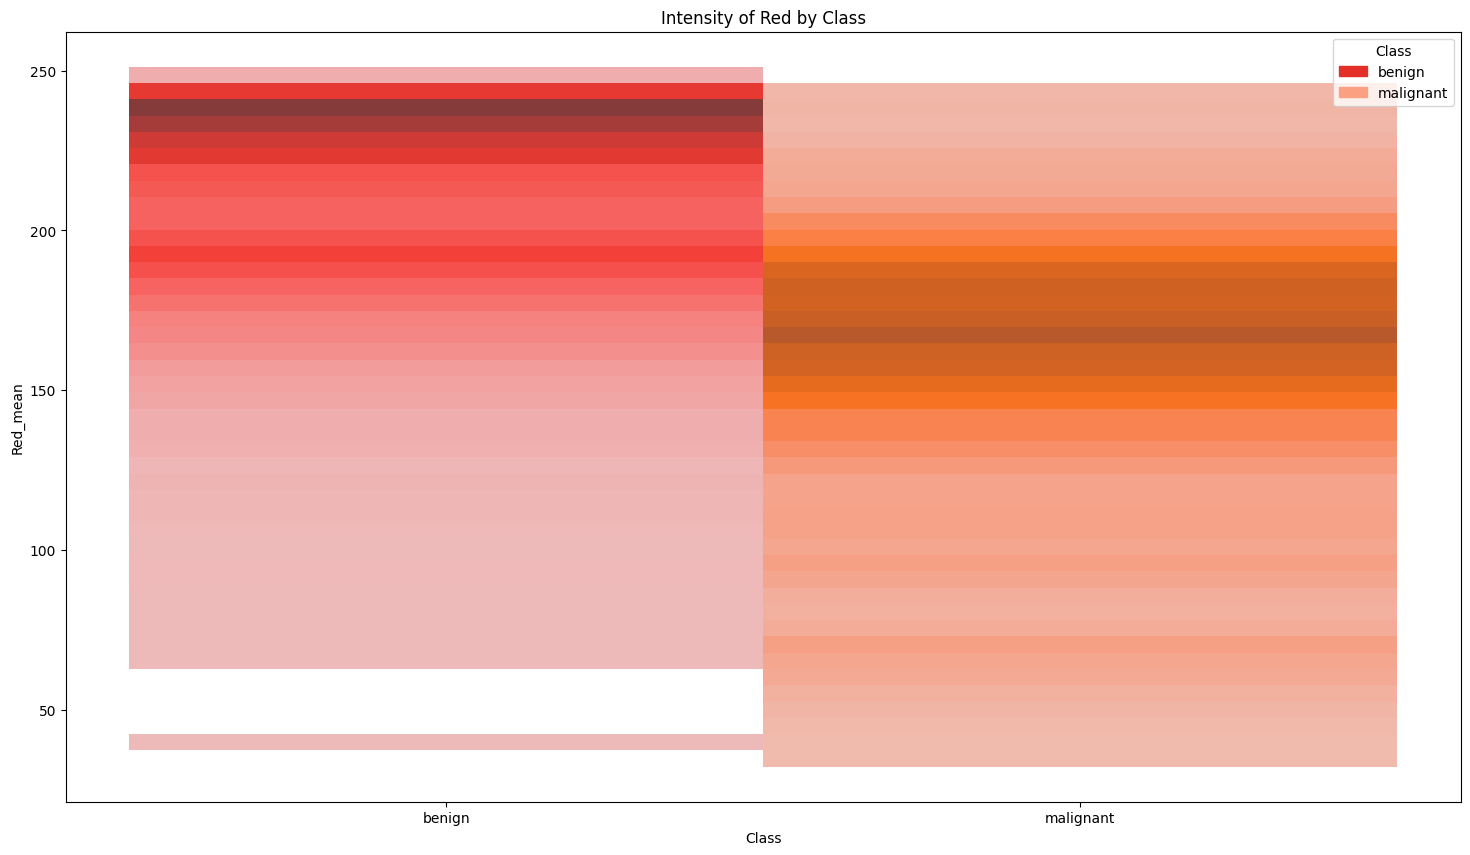

In [ ]:
# Create figure on which to plot & compare mean color data
plt.figure(figsize=(18,10))

# Build histogram to compare color means by training class
sns.histplot(data=full_df, x = 'Class', y = 'Red_mean', hue = 'Class', palette = 'Reds_r')

# Set plot title and labels
plt.title('Intensity of Red by Class')
plt.xlabel('Class')

# Reveal plot
plt.show()

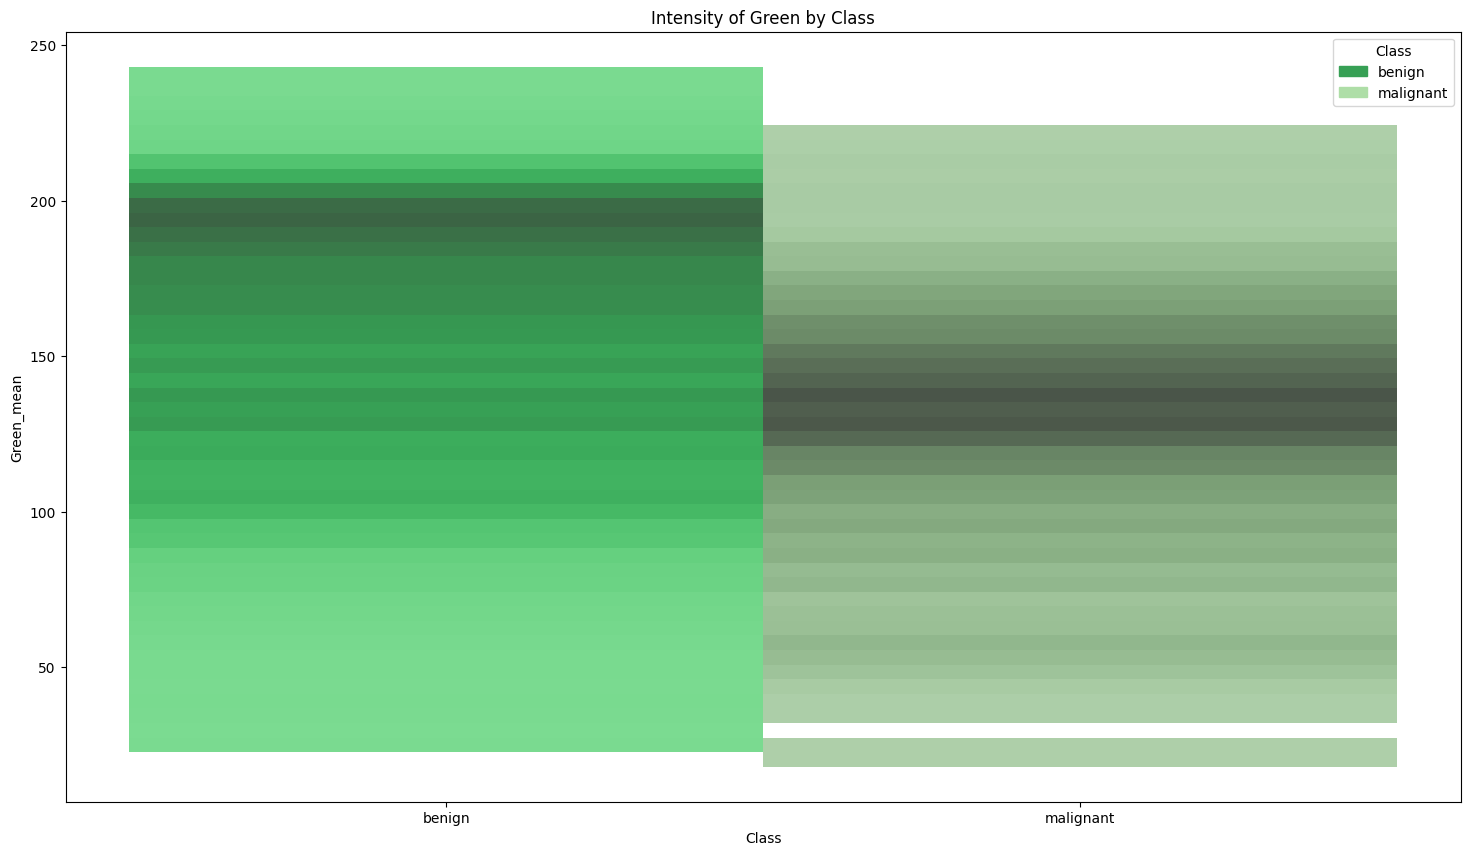

In [ ]:
# Create figure on which to plot & compare mean color data
plt.figure(figsize=(18,10))

# Build histogram to compare color means by training class
sns.histplot(data=full_df, x = 'Class', y = 'Green_mean', hue = 'Class', palette = 'Greens_r')

# Set plot title and labels
plt.title('Intensity of Green by Class')
plt.xlabel('Class')

# Reveal plot
plt.show()

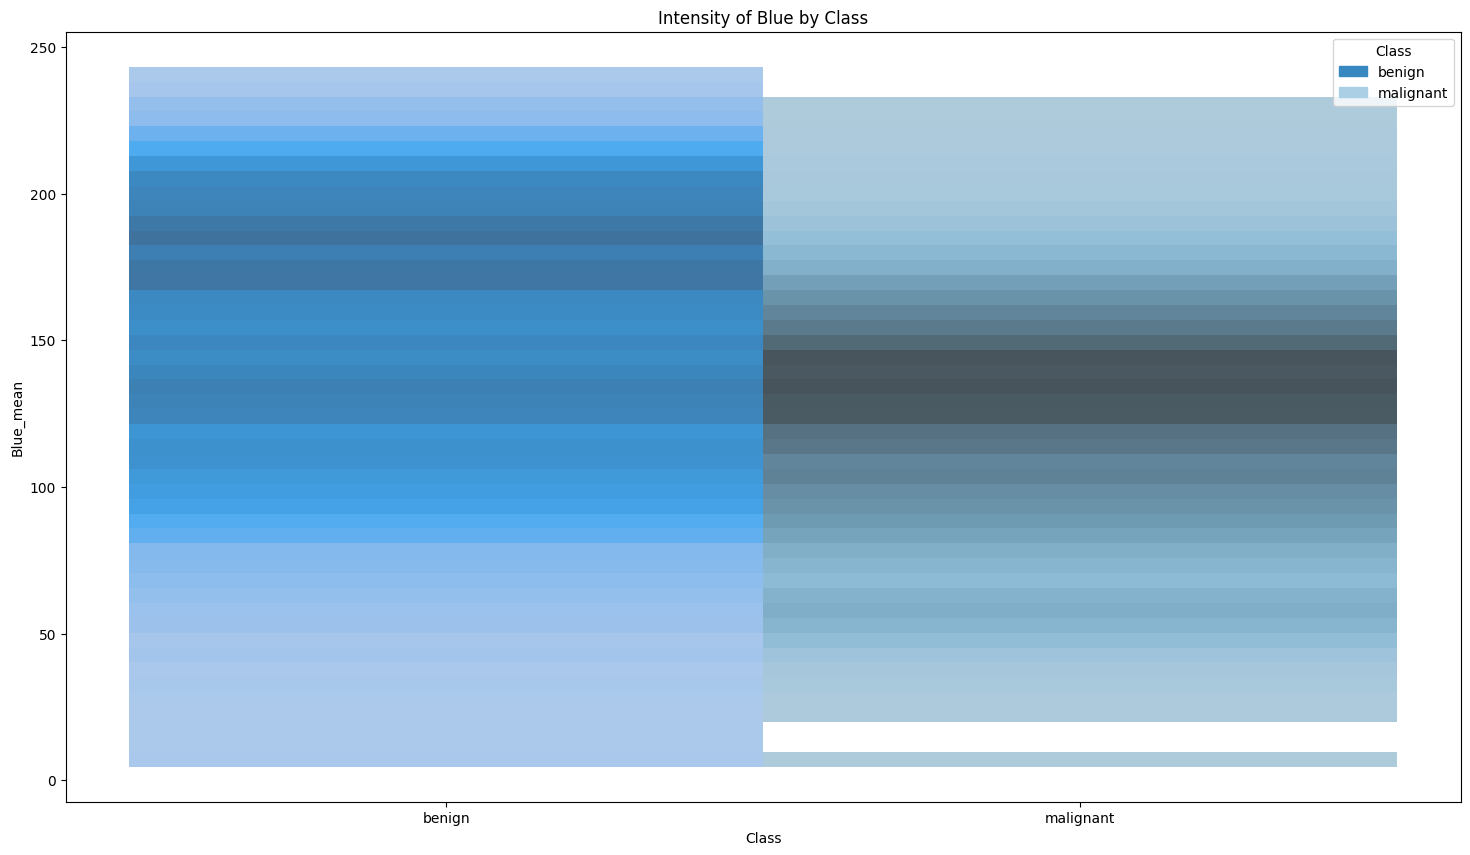

In [ ]:
# Create figure on which to plot & compare mean color data
plt.figure(figsize=(18,10))

# Build histogram to compare color means by training class
sns.histplot(data=full_df, x = 'Class', y = 'Blue_mean', hue = 'Class', palette = 'Blues_r')

# Set plot title and labels
plt.title('Intensity of Blue by Class')
plt.xlabel('Class')

# Reveal plot
plt.show()

## Dataset Augmentation
Although our training dataset of 10,000 images may appear quite large, similar projects have required hundreds of thousands or even millions of images to attain a level of precision and accuracy appropriate for deployment in the medical field.

In order to approach this industry-class level of readiness, we need to artificially increase the size of our dataset. We will achieve this by "jittering", or randomly modifying, the visual qualities of copies of images in our dataset, in order to simulate the diverse medical imaging conditions our model may encounter in the real world. We will also rotate our images to ensure that our model does not overfit to a particular orientation of lesion, increasing our model's accuracy in real-world scenarios.

Below, we've written some functions that we'll use later while training our model to augment our training data.

In [ ]:
# Define function to jitter our images
def color_jitter(image):

  # Create a copy of the image passed to the function
  img = image.copy()

  # Randomly enhance image brightness
  img = ImageEnhance.Brightness(img).enhance(np.random.uniform(0.8, 1.2))

  # Randomly enhance image contrast
  img = ImageEnhance.Contrast(img).enhance(np.random.uniform(0.8, 1.2))

  # Randomly enhance image color
  img = ImageEnhance.Color(img).enhance(np.random.uniform(0.8, 1.2))

  # Randomly enhance image sharpness
  img = ImageEnhance.Sharpness(img).enhance(np.random.uniform(0.8, 1.2))

  # Return enhanced image
  return img

# Define a function to rotate image
def rotate_image(image, angle):

  # Return rotated image
  return image.rotate(angle)

# Define a function to augment our train set
def augment_fold_train_set(dataset, indices, output_dir, jitters = 2):

  # Create a directory to hold our augmented train images
  os.makedirs(output_dir, exist_ok = True)

  # Iterate over all indices passed
  for index in tqdm(indices, desc = "Augmenting train set..."):

    # Extract filepath and class index for index of dataset
    path, class_index = dataset.samples[index]

    # Extract class name based on class index
    cls = dataset.classes[class_index]

    # Extract image at path, ensuring RGB colorscale for safety
    img = Image.open(path).convert('RGB')

    # Extract base of image path
    base = os.path.splitext(os.path.basename(path))[0]

    # Define file extension expected
    ext = '.jpg'

    # Define path to class folder in output directory
    class_folder = os.path.join(output_dir, cls)

    # Create class folder
    os.makedirs(class_folder, exist_ok = True)

    # Save original image in class folder
    img.save(os.path.join(class_folder, base + 'OG' + ext))

    # Iterate over rotation angles
    for angle in [90, 180, 270]:

      # Rotate original image
      rotated = rotate_image(img, angle)

      # Save rotated original image
      rotated.save(os.path.join(class_folder, base + f'rot{angle}' + ext))

    # Iterate over specified number of jitters
    for j in range(jitters):

      # Jitter image color, contrast, brightness and sharpness
      jittered = color_jitter(img)

      # Save jittered image in class folder
      jittered.save(os.path.join(class_folder, base + f'jitter{j}' + ext))

      # Iterate over rotation angles
      for angle in [90, 180, 270]:

        # Rotate jittered image
        rotated = rotate_image(jittered, angle)

        # Save rotated jittered image
        rotated.save(os.path.join(class_folder, base + f'jitrot{angle}' + ext))

## Convolutional Neural Network
Here is where the real fun starts!

Convolutional neural networks, or CNNs, are incredible machine learning architectures that leverage complex linear algebra and calculus to actually *learn* information from images. How does it do this? Essentially, it examines groups of pixels from right to left, top to bottom, to decide how much that group of pixels looks like what it's trained to look for. The network has multiple convolutions (essentially layers) that build up from recognizing simple lines to shapes to groups of shapes to objects and finally to entire image contents.

We'll see a bit more of how this works in the coming code. The main action takes place during training and testing, when our model will teach itself the characteristics of benign and malignant images using our train set, and then try to predict the class of the test set based on what it's learned.

### Experiment Tracking

Sounds simple, right? Well, like any software development process, success requires plenty of iterations and tweaks. One tool that will help us track our iterations (often called experiments in machine learning) is called [Weights & Biases](https://wandb.ai/site/).

This tool will allow us to easily track and visualize a bunch of success metrics for our CNN as we tweak its *hyperparameters*. "Hyperparameters" is a big word that essentially means "the ways we configure how our CNN will learn." Below, we'll log into Weights and Biases and define a configuration that contains all the hyperparameters we'll use for the current run.

In [ ]:
# Log into Weights & Biases for experiment tracking
!wandb login --relogin

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
# Initialize Weights & Biases tracking of our project
# and define hyperparameters of current run
wandb.init(
    project='melanoma-classifier',
    config={
        'base': 'EfficientNetV2B0',
        'img_size': 256,
        'batch_size': 16,
        'learn_rate': 0.0001,
        'dropout_ratio': 0.5,
        'dense_units': 512,
        'epochs': 30,
        'finetune_after': 8,
        'unfreeze_pct': 0.25,
        'k': 5,
        'patience_steps': 6,
        'weight_decay': 1e-4,
        'grad_clip': 1.0,
        'warmup_epochs': 3,
        'optimizer': 'AdamW'
    }
)

# Define a variable to hold our config for easy referencing
config = wandb.config

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: jkelle11 (jkelle11-university-of-maryland) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Hardware Check
Now before we begin this run of our CNN, it's important to check that a GPU is available. A GPU (Graphics Processing Unit) is a special kind of computer chip that can run millions of small calculations in parallel at once, which is exactly what powers the magic of neural networks.

If GPU is not available in our Colab environment, we'll have to rely on CPU, which is *much* slower.

In [ ]:
# If a GPU is available
if torch.cuda.is_available():

    # Define a variable to refer to GPU
    chip = torch.device('cuda')

    # Notify user of type of GPU
    print(f'\nGPU in Use: {torch.cuda.get_device_name(0)}')

    # Notify user of GPU memory specs
    print(f'\nGPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')

    # Notify user of CUDA version (language for communicating w/ GPU)
    print(f'\nCUDA Version: {torch.version.cuda}')

    # Turn on benchmarking to speed up CNN training
    torch.backends.cudnn.benchmark = True

# If GPU is not available
else:

    # Define a variable to refer to CPU
    chip = torch.device('cpu')

    # Notify user that GPU is not available
    print('\nCaution: Only CPU currently available')


GPU in Use: NVIDIA A100-SXM4-80GB

GPU Memory: 85.17 GB

CUDA Version: 12.6


### Data Preparation
Now that we've configured our chip, we'll unzip our training set images so our CNN can ingest them.

In [ ]:
# Define path to zipped train set
train_zip = "/content/drive/MyDrive/DATA602_Final_Project/train_resized.zip"

# Define path to output unzipped train set
unzipped_train = "/content/Unzipped_Train"

# If path to unzipped train set exists from previous run
if os.path.exists(unzipped_train):

  # Remove leftover folder
  shutil.rmtree(unzipped_train)

# Open zipped train set as read-only
with zipfile.ZipFile(train_zip, 'r') as zipped_train:

  # Extract all images into unzipped train folder,
  # preserving class subfolders
  zipped_train.extractall(unzipped_train)

# Notify user that extraction is complete
print("Extraction complete.")

Extraction complete.


Next, we'll create a folder to hold checkpoints from our model training, so that if training is interrupted for some reason, we won't lose all our progress!

In [ ]:
# Define path to checkpoint folder
checkpoints_folder = "/content/drive/MyDrive/DATA602_Final_Project/model_checkpoints3"

# Create checkpoint folder at path
os.makedirs(checkpoints_folder, exist_ok=True)

# Define name of checkpoint file
checkpoint_f = f"{checkpoints_folder}/training_checkpoint.pkl"

For our final data preparation step, we'll normalize the color channel values of our images using the ImageNet means and standard deviations. To explain what these are, we'll have to back up and discuss transfer learning.

Training CNNs from scratch is very, very computationally expensive. The models need to learn how to recognize lines, then shapes, then combinations of shapes, then objects, and finally entire image contents. As a couple of college students, we simply don't have the compute resources or money needed for this process. Luckily, instead of running this expensive and extremely long training from scratch, we can take a faster, simpler approach: *transfer learning*.

Transfer learning involves importing an existing CNN that has already learned how to recognize lines, shapes, combinations of shapes, objects, and entire image contents. We then add a few custom neural layers on top of that CNN that will learn how to classify the image it's recognized as either benign or malignant melanoma. This approach saves us a ton of time and computational cost, not just on model training, but also on experimentation and tweaking hyperparameters.

Our model will leverage transfer learning from the EfficientNetV2-B0 CNN, a model trained on the ImageNet dataset. In order to match our data to the ENV2-B0 model's assumptions and thus speed up its learning, we'll normalize our images' color channels to the mean and standard deviation that this model was trained on. Check out these next steps below!

In [ ]:
# Define lists of ImageNet color channel means and standard deviations
imagenet_means = [0.485, 0.456, 0.406]
imagenet_stds = [0.229, 0.224, 0.225]

# Create data preparation pipeline
data_prep = transforms.Compose([

    # Convert images to tensor format
    transforms.ToTensor(),

    # Normalize images' color channels by ImageNet summary stats
    transforms.Normalize(imagenet_means, imagenet_stds)
])

# Create ImageFolder object of our train set,
# applying data preparation pipeline
train_full_set = datasets.ImageFolder(root=unzipped_train, transform = data_prep)

# Extract indexes of train set
indexes = list(range(len(train_full_set)))

# Extract class labels of train set images
labels = [train_full_set.imgs[i][1] for i in indexes]

# Notify user of train set size
print(f"\nLoaded {len(train_full_set)} images")

# Notify user of train set classes
print(f"\nClasses: {train_full_set.classes}")

# Notify user of class distribution for imbalance checking
print(f"\nClass distribution: {np.bincount(labels)}\n")


Loaded 9605 images

Classes: ['benign', 'malignant']

Class distribution: [5000 4605]



### K-Folds Cross-Validation
One last thing before we begin our main training loop: we need to set up *K-folds Cross-Validation*. This sounds complex, but it's actually pretty simple:

1.   We choose an integer (K).
2.   We split our train set into K equally-sized subsets.
1.   We train our CNN on K - 1 of these subsets.
2.   We evaluate our CNN's performance on the Kth subset.
1.   We repeat this process until each subset has served as the evaluation (validation) set exactly once.

This technique allows us to avoid overly trusting a single training process to follow the absolute best path. This is important because the complexity of neural networks means that a lot can go wrong and prevent our CNN from learning the best ways to distinguish benign and malignant melanoma.

With K-Folds Cross-Validation, we can create K models and compare their performance. This allows us to better estimate the generalization performance of our architecture, again by not simply relying on one training run (which could result in unrealistically high performance), but by averaging the performances of the same architecture trained on different subsets of data.


In [ ]:
# Define Stratified K Fold object
stratkf = StratifiedKFold(n_splits=config['k'], shuffle=True, random_state=23)

# Create variable to track current fold
curr_fold = 0

# Create list to hold recall scores of each fold's model
fold_val_recalls = []

# Create list to hold recall score curves of each fold's model
fold_recall_curves = []

# Check if previous model checkpoints exist
# (i.e., training was interrupted)
if os.path.exists(checkpoint_f):

    # Open checkpoint file in read-binary mode
    with open(checkpoint_f, 'rb') as cp:

        # Extract checkpoint data
        checkp = pickle.load(cp)

        # Define fold to resume from
        curr_fold = checkp['last_completed_fold'] + 1

        # Extract recall score list to resume building
        fold_val_recalls = checkp['fold_val_recalls']

        # Notify user that checkpoint was found
        print(f"Resuming from fold {curr_fold + 1}\n")

### Model Training
This is where our model learns! As mentioned before, there is a bit of complex linear algebra and calculus involved in this process. Follow along with the code comments to learn more!

In [ ]:
# Iterate over all K-Folds
for fold, (train_index, val_index) in enumerate(stratkf.split(indexes, labels)):

    # Notify user of current fold
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1} / {config['k']}")
    print(f"{'='*50}")

    # Skip fold if completed in previous checkpoint
    if fold < curr_fold:
        print(f"Fold {fold + 1} already completed.\n")
        continue

    # Define path to augmented train directory
    augmented_train_dir = f'/content/augmented_fold{fold}_train'

    # Remove augmented train directory if already exists
    if os.path.exists(augmented_train_dir):
      shutil.rmtree(augmented_train_dir)

    # Augment train set for current fold and
    # output in augmented train directory
    augment_fold_train_set(train_full_set, train_index, augmented_train_dir)

    # Create ImageFolder object from augmented train directory,
    # applying data preparation pipeline
    train_set = datasets.ImageFolder(augmented_train_dir, transform = data_prep)

    # Create validation set as subset of full train set
    val_set = Subset(train_full_set, val_index)

    # Create DataLoader to serve batches of training data
    # to model
    train_loader = DataLoader(train_set, batch_size=config['batch_size'],
                              shuffle=True, num_workers=2, pin_memory=True)

    # Create DataLoader to serve batches of validation data
    # to model
    val_loader = DataLoader(val_set, batch_size=config['batch_size'],
                            shuffle=False, num_workers=2, pin_memory=True)

    # Notify user of train set and validation set size
    print(f"\nTrain samples: {len(train_set)} | Val samples: {len(val_set)}\n")

    # Create EfficientNetV2-B0 instance to use as base model
    ENV2B0 = timm.create_model('tf_efficientnetv2_b0', pretrained=True,
                                num_classes=0, global_pool='avg')

    # Ensure base model does not change for now
    for param in ENV2B0.parameters():
        param.requires_grad = False

    # Define architecture of custom melanoma classifier
    classifier_head = torch.nn.Sequential(

        # Linear layer that learns and applies parameters to
        # inputs, just like regression computes parameters
        # for variables
        torch.nn.Linear(ENV2B0.num_features, config['dense_units']),

        # Normalization layer that normalizes batch
        # output of previous layer
        torch.nn.BatchNorm1d(config['dense_units']),

        # Activation function that introduces nonlinearity,
        # allowing our model to learn complex patterns
        torch.nn.ReLU(),

        # Randomly turn off a certain proportion of
        # our model's neurons, preventing our model
        # from simply memorizing training data
        # instead of learning its important patterns
        torch.nn.Dropout(config['dropout_ratio']),

        # Another linear layer
        torch.nn.Linear(config['dense_units'], 1),

        # Final layer that outputs a computed probability
        # of malignancy for each image
        torch.nn.Sigmoid()
    )

    # Combine our pretrained model with our custom classifier
    model = torch.nn.Sequential(ENV2B0, classifier_head).to(chip)

    # Create loss function to calculate model error
    loss_bce = torch.nn.BCELoss()

    # Create initial learning rate, which decides how fast our model will learn
    initial_lr = config['learn_rate'] * 0.1 if config['warmup_epochs'] > 0 else config['learn_rate']

    # Create optimizer that will guide our model in learning
    optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr,
                                  weight_decay=config['weight_decay'])

    # Create scheduler to adapt our learning rate if our model stops improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )

    # Create variable to hold best recall
    best_recall = 0.0

    # Create variable to hold epoch patience. i.e., the number
    # of epochs we've run without our model improving
    patience = 0

    # Create variable to signify whether fine-tuning is complete
    ft_done = False

    # Create list to store epoch recall scores
    epoch_recalls = []

    # Create curve to hold best fold recall score for plotting later
    best_recall_curve = None

    # Iterate over all training epochs
    for epoch in range(config['epochs']):

        # Check if current training epoch is a warmup epoch
        if epoch < config['warmup_epochs']:

            # Compute warmup factor and warmup epoch learning rate
            warmup_factor = (epoch + 1) / config['warmup_epochs']
            warmup_lr = config['learn_rate'] * warmup_factor

            # Propagate warmup learning rate to all parameters
            for param_group in optimizer.param_groups:
                param_group['lr'] = warmup_lr

        # If current epoch is not a warmup epoch,
        # keep main learning rate
        elif epoch == config['warmup_epochs']:
            for param_group in optimizer.param_groups:
                param_group['lr'] = config['learn_rate']

        # If fine-tuning is not complete and it's time to fine-tune
        if not ft_done and epoch == config['finetune_after']:

            # Extract all parameters from pretrained base model
            total_params = list(ENV2B0.parameters())

            # Calculate unfreezing threshold, or number of parameters
            # in pretrained model we will retrain to capture additional
            # accuracy and recall score
            threshold = int(len(total_params) * (1 - config['unfreeze_pct']))

            # Iterate over all parameters
            for i, param in enumerate(total_params):

                # If parameter is above threshold
                if i >= threshold:

                    # Unfreeze parameter (set to learning mode)
                    param.requires_grad = True

            # Create optimizer that will guide our pretrained model's
            # parameters in re-learning
            optimizer = torch.optim.AdamW(
                filter(lambda x: x.requires_grad, model.parameters()),
                lr=config['learn_rate'] / 10,
                weight_decay=config['weight_decay'] / 10
            )

            # Create scheduler to adapt our learning rate if our model stops improving
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-8
            )

            # Mark fine-tuning as complete
            ft_done = True
            print(f"Fine-tuning activated at epoch {epoch + 1}")

        # Set model to training mode
        model.train()

        # Create variables to hold training set loss and total data trained on
        train_loss, total = 0.0, 0

        # Create list to hold predictions, true class labels,
        # and predicted probabilities
        train_all_preds, train_all_labels, train_all_probs = [], [], []

        # Iterate over all images in each batch
        for images, labels_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):

            # Load images and class labels to device
            images = images.to(chip)
            labels_batch = labels_batch.float().unsqueeze(1).to(chip)

            # Reset optimizer gradient
            optimizer.zero_grad()

            # Predict class of images using model
            outputs = model(images)

            # Calculate loss
            loss = loss_bce(outputs, labels_batch)

            # Backpropagate partial derivatives of loss so that
            # optimizer knows how to adjust weights
            loss.backward()

            # Prevent exploding gradients for training stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])

            # Adjust weights according to backpropagated loss
            optimizer.step()

            # Increment total train loss
            train_loss += loss.item() * images.size(0)

            # Extract predicted class labels
            predicted_labels = (outputs > 0.5)

            # Add batch predictions to list
            train_all_preds.extend(predicted_labels.cpu().numpy().flatten())

            # Add batch true labels to list
            train_all_labels.extend(labels_batch.cpu().numpy().flatten())

            # Add batch predicted probabilities to list
            train_all_probs.extend(outputs.detach().cpu().numpy().flatten())

            # Increment total data trained on by batch size
            total += labels_batch.size(0)

        # Calculate average train loss
        train_loss /= total

        # Compute training set recall score
        train_recall = recall_score(train_all_labels, train_all_preds, zero_division=0)

        # Compute training set precision score
        train_precision = precision_score(train_all_labels, train_all_preds, zero_division=0)

        # Compute training set F1 score
        train_f1 = f1_score(train_all_labels, train_all_preds, zero_division=0)

        # Compute training set ROC-AUC score
        train_auc = roc_auc_score(train_all_labels, train_all_probs) if len(set(train_all_labels)) > 1 else 0.0

        # Set model to evaluation mode
        model.eval()

        # Create variables to hold validation set loss and total data validated on
        val_loss, total = 0.0, 0

        # Create list to hold predictions, true class labels,
        # and predicted probabilities
        val_all_preds, val_all_labels, val_all_probs = [], [], []

        # Turn off gradient tracking (loss computation)
        with torch.no_grad():

            # Iterate over all images in each batch
            for images, labels_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):

                # Load images and class labels to device
                images = images.to(chip)
                labels_batch = labels_batch.float().unsqueeze(1).to(chip)

                # Predict class of images using model
                outputs = model(images)

                # Calculate loss
                loss = loss_bce(outputs, labels_batch)

                # Increment total validation loss
                val_loss += loss.item() * images.size(0)

                # Extract predicted class labels
                predicted_labels = (outputs > 0.5)

                # Add batch predictions to list
                val_all_preds.extend(predicted_labels.cpu().numpy().flatten())

                # Add batch true labels to list
                val_all_labels.extend(labels_batch.cpu().numpy().flatten())

                # Add batch predicted probabilities to list
                val_all_probs.extend(outputs.cpu().numpy().flatten())

                # Increment total data validated on by batch size
                total += labels_batch.size(0)

        # Calculate average validation loss
        val_loss /= total

        # Compute validation set recall score
        val_recall = recall_score(val_all_labels, val_all_preds, zero_division=0)

        # Append recall score to epoch list
        epoch_recalls.append(val_recall)

        # Compute validation set precision score
        val_precision = precision_score(val_all_labels, val_all_preds, zero_division=0)

        # Compute validation set F1 score
        val_f1 = f1_score(val_all_labels, val_all_preds, zero_division=0)

        # Compute validation set ROC-AUC score
        val_auc = roc_auc_score(val_all_labels, val_all_probs) if len(set(val_all_labels)) > 1 else 0.0

        # Update scheduler
        scheduler.step(val_loss)

        # Log epoch stats to W&B
        wandb.log(
            {
                'fold': fold + 1,
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_recall': train_recall,
                'train_precision': train_precision,
                'train_f1': train_f1,
                'train_auc': train_auc,
                'val_loss': val_loss,
                'val_recall': val_recall,
                'val_precision': val_precision,
                'val_f1': val_f1,
                'val_auc': val_auc,
                'learning_rate': optimizer.param_groups[0]['lr']
            }
        )

        # Print epoch metrics
        print(f"\nEpoch {epoch + 1}:")
        print(f"  Train → Loss: {train_loss:.4f} | Recall: {train_recall:.4f} | Precision: {train_precision:.4f} | F1: {train_f1:.4f} | AUC: {train_auc:.4f}")
        print(f"  Val   → Loss: {val_loss:.4f} | Recall: {val_recall:.4f} | Precision: {val_precision:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.2e}\n")

        # Check if validation recall score achieved
        # exceeds previous best
        if val_recall > best_recall:

            # Store best validation recall score achieved
            best_recall = val_recall

            # Define path to checkpoint save file
            savepath = f"{checkpoints_folder}/best_model_fold{fold}.pt"

            # Save checkpoint
            torch.save(model.state_dict(), savepath)

            # Reset patience
            patience = 0

            # Notify user of save and best recall score yet achieved
            print(f"Model saved! (Best recall: {best_recall:.4f})")

        # If validation recall score not improved
        else:

            # Increment patience
            patience += 1

            # If patience exceeds pre-set limit
            # (i.e., model has stopped improving)
            if patience >= config['patience_steps']:

                # Stop early to avoid wasting resources
                # and notify user
                print(f"Early stopping at epoch {epoch + 1}")
                break

    # Load best model of current fold
    model.load_state_dict(torch.load(f"{checkpoints_folder}/best_model_fold{fold}.pt"))

    # Set model to evaluation mode
    model.eval()

    # Create variables to hold validation set loss and total data validated on
    val_loss, total = 0.0, 0

    # Create list to hold predictions, true class labels,
    # and predicted probabilities
    final_preds, final_labels, final_probs = [], [], []

    # Turn off gradient tracking (loss computation)
    with torch.no_grad():

        # Iterate over all images in each batch
        for images, labels_batch in val_loader:

            # Load images and class labels to device
            images = images.to(chip)
            labels_batch = labels_batch.float().unsqueeze(1).to(chip)

            # Predict class of images using model
            outputs = model(images)

            # Calculate loss
            loss = loss_bce(outputs, labels_batch)

            # Increment total validation loss
            val_loss += loss.item() * images.size(0)

            # Extract predicted class labels
            predicted_labels = (outputs > 0.5)

            # Add batch predictions to list
            final_preds.extend(predicted_labels.cpu().numpy().flatten())

            # Add batch true labels to list
            final_labels.extend(labels_batch.cpu().numpy().flatten())

            # Add batch predicted probabilities to list
            final_probs.extend(outputs.cpu().numpy().flatten())

            # Increment total data validated on by batch size
            total += labels_batch.size(0)

    # Calculate average validation loss
    val_loss /= total

    # Compute validation set recall score
    val_recall = recall_score(final_labels, final_preds, zero_division=0)

    # Compute validation set precision score
    val_precision = precision_score(final_labels, final_preds, zero_division=0)

    # Compute validation set F1 score
    val_f1 = f1_score(final_labels, final_preds, zero_division=0)

    # Compute validation set ROC-AUC score
    val_auc = roc_auc_score(final_labels, final_probs) if len(set(final_labels)) > 1 else 0.0

    # Append validation recall score to fold list
    fold_val_recalls.append(val_recall)

    # Append fold validation recall score curve to list
    fold_recall_curves.append(list(epoch_recalls))

    # Notify user of final fold results
    print(f"\nFOLD {fold + 1} FINAL RESULTS:\n")
    print(f"\nRecall: {val_recall:.4f} | Precision: {val_precision:.4f} | F1: {val_f1:.4f} | AUC: {val_auc:.4f} | Loss: {val_loss:.4f}")

    # Define fold checkpoint
    checkpoint = {
        'last_completed_fold': fold,
        'fold_val_recalls': fold_val_recalls,
        'config': dict(config)
    }

    # Save fold checkpoint
    with open(checkpoint_f, 'wb') as cp:
        pickle.dump(checkpoint, cp)
    print(f"Fold {fold + 1}: Checkpoint saved.\n")


FOLD 1 / 5


Augmenting train set...: 100%|██████████| 7684/7684 [01:54<00:00, 67.23it/s]



Train samples: 69156 | Val samples: 1921



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/28.8M [00:00<?, ?B/s]

Epoch 1 [Val]: 100%|██████████| 121/121 [00:11<00:00, 10.92it/s]



Epoch 1:
  Train → Loss: 0.2959 | Recall: 0.8537 | Precision: 0.8830 | F1: 0.8681 | AUC: 0.9454
  Val   → Loss: 0.2211 | Recall: 0.8610 | Precision: 0.9543 | F1: 0.9053 | AUC: 0.9721
  LR: 3.33e-05

Model saved! (Best recall: 0.8610)


Epoch 2 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.27it/s]



Epoch 2:
  Train → Loss: 0.2476 | Recall: 0.8843 | Precision: 0.9037 | F1: 0.8939 | AUC: 0.9620
  Val   → Loss: 0.2008 | Recall: 0.9034 | Precision: 0.9286 | F1: 0.9158 | AUC: 0.9741
  LR: 6.67e-05

Model saved! (Best recall: 0.9034)


Epoch 3 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.76it/s]



Epoch 3:
  Train → Loss: 0.2295 | Recall: 0.8947 | Precision: 0.9142 | F1: 0.9043 | AUC: 0.9677
  Val   → Loss: 0.1927 | Recall: 0.9012 | Precision: 0.9432 | F1: 0.9217 | AUC: 0.9756
  LR: 1.00e-04



Epoch 4 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.16it/s]



Epoch 4:
  Train → Loss: 0.2136 | Recall: 0.9027 | Precision: 0.9204 | F1: 0.9114 | AUC: 0.9720
  Val   → Loss: 0.2028 | Recall: 0.8817 | Precision: 0.9632 | F1: 0.9206 | AUC: 0.9773
  LR: 1.00e-04



Epoch 5 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.52it/s]



Epoch 5:
  Train → Loss: 0.2051 | Recall: 0.9050 | Precision: 0.9270 | F1: 0.9159 | AUC: 0.9742
  Val   → Loss: 0.2046 | Recall: 0.8708 | Precision: 0.9593 | F1: 0.9129 | AUC: 0.9774
  LR: 1.00e-04



Epoch 6 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.84it/s]



Epoch 6:
  Train → Loss: 0.1944 | Recall: 0.9129 | Precision: 0.9290 | F1: 0.9209 | AUC: 0.9769
  Val   → Loss: 0.1971 | Recall: 0.9099 | Precision: 0.9448 | F1: 0.9270 | AUC: 0.9774
  LR: 1.00e-04

Model saved! (Best recall: 0.9099)


Epoch 7 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.92it/s]



Epoch 7:
  Train → Loss: 0.1895 | Recall: 0.9156 | Precision: 0.9321 | F1: 0.9238 | AUC: 0.9781
  Val   → Loss: 0.1956 | Recall: 0.9055 | Precision: 0.9499 | F1: 0.9272 | AUC: 0.9777
  LR: 5.00e-05



Epoch 8 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.42it/s]



Epoch 8:
  Train → Loss: 0.1767 | Recall: 0.9207 | Precision: 0.9365 | F1: 0.9285 | AUC: 0.9808
  Val   → Loss: 0.1877 | Recall: 0.9153 | Precision: 0.9388 | F1: 0.9269 | AUC: 0.9782
  LR: 5.00e-05

Model saved! (Best recall: 0.9153)
Fine-tuning activated at epoch 9


Epoch 9 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.74it/s]



Epoch 9:
  Train → Loss: 0.1592 | Recall: 0.9285 | Precision: 0.9451 | F1: 0.9367 | AUC: 0.9844
  Val   → Loss: 0.1855 | Recall: 0.9131 | Precision: 0.9535 | F1: 0.9329 | AUC: 0.9813
  LR: 1.00e-05



Epoch 10 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.56it/s]



Epoch 10:
  Train → Loss: 0.1346 | Recall: 0.9375 | Precision: 0.9556 | F1: 0.9465 | AUC: 0.9886
  Val   → Loss: 0.1881 | Recall: 0.9218 | Precision: 0.9518 | F1: 0.9366 | AUC: 0.9814
  LR: 1.00e-05

Model saved! (Best recall: 0.9218)


Epoch 11 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.29it/s]



Epoch 11:
  Train → Loss: 0.1203 | Recall: 0.9452 | Precision: 0.9626 | F1: 0.9538 | AUC: 0.9908
  Val   → Loss: 0.2041 | Recall: 0.9121 | Precision: 0.9677 | F1: 0.9391 | AUC: 0.9831
  LR: 1.00e-05



Epoch 12 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.62it/s]



Epoch 12:
  Train → Loss: 0.0998 | Recall: 0.9533 | Precision: 0.9691 | F1: 0.9611 | AUC: 0.9934
  Val   → Loss: 0.1901 | Recall: 0.9186 | Precision: 0.9570 | F1: 0.9374 | AUC: 0.9835
  LR: 1.00e-05



Epoch 13 [Val]: 100%|██████████| 121/121 [00:02<00:00, 56.14it/s]



Epoch 13:
  Train → Loss: 0.0924 | Recall: 0.9586 | Precision: 0.9712 | F1: 0.9649 | AUC: 0.9946
  Val   → Loss: 0.2061 | Recall: 0.9131 | Precision: 0.9656 | F1: 0.9386 | AUC: 0.9840
  LR: 5.00e-06



Epoch 14 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.92it/s]



Epoch 14:
  Train → Loss: 0.0782 | Recall: 0.9651 | Precision: 0.9764 | F1: 0.9707 | AUC: 0.9958
  Val   → Loss: 0.1969 | Recall: 0.9175 | Precision: 0.9580 | F1: 0.9373 | AUC: 0.9840
  LR: 5.00e-06



Epoch 15 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.05it/s]



Epoch 15:
  Train → Loss: 0.0742 | Recall: 0.9673 | Precision: 0.9770 | F1: 0.9721 | AUC: 0.9963
  Val   → Loss: 0.2208 | Recall: 0.9077 | Precision: 0.9687 | F1: 0.9372 | AUC: 0.9836
  LR: 5.00e-06



Epoch 16 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.12it/s]



Epoch 16:
  Train → Loss: 0.0704 | Recall: 0.9685 | Precision: 0.9793 | F1: 0.9739 | AUC: 0.9966
  Val   → Loss: 0.1943 | Recall: 0.9305 | Precision: 0.9554 | F1: 0.9428 | AUC: 0.9843
  LR: 5.00e-06

Model saved! (Best recall: 0.9305)


Epoch 17 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.10it/s]



Epoch 17:
  Train → Loss: 0.0666 | Recall: 0.9732 | Precision: 0.9803 | F1: 0.9767 | AUC: 0.9970
  Val   → Loss: 0.2081 | Recall: 0.9283 | Precision: 0.9607 | F1: 0.9442 | AUC: 0.9842
  LR: 2.50e-06



Epoch 18 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.88it/s]



Epoch 18:
  Train → Loss: 0.0626 | Recall: 0.9726 | Precision: 0.9819 | F1: 0.9772 | AUC: 0.9973
  Val   → Loss: 0.2323 | Recall: 0.9045 | Precision: 0.9675 | F1: 0.9349 | AUC: 0.9846
  LR: 2.50e-06



Epoch 19 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.51it/s]



Epoch 19:
  Train → Loss: 0.0597 | Recall: 0.9751 | Precision: 0.9830 | F1: 0.9790 | AUC: 0.9975
  Val   → Loss: 0.2092 | Recall: 0.9251 | Precision: 0.9595 | F1: 0.9420 | AUC: 0.9839
  LR: 2.50e-06



Epoch 20 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.65it/s]



Epoch 20:
  Train → Loss: 0.0580 | Recall: 0.9756 | Precision: 0.9841 | F1: 0.9798 | AUC: 0.9977
  Val   → Loss: 0.2216 | Recall: 0.9207 | Precision: 0.9669 | F1: 0.9433 | AUC: 0.9844
  LR: 2.50e-06



Epoch 21 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.72it/s]



Epoch 21:
  Train → Loss: 0.0530 | Recall: 0.9769 | Precision: 0.9846 | F1: 0.9807 | AUC: 0.9980
  Val   → Loss: 0.2090 | Recall: 0.9327 | Precision: 0.9513 | F1: 0.9419 | AUC: 0.9846
  LR: 1.25e-06

Model saved! (Best recall: 0.9327)


Epoch 22 [Val]: 100%|██████████| 121/121 [00:02<00:00, 56.01it/s]



Epoch 22:
  Train → Loss: 0.0527 | Recall: 0.9776 | Precision: 0.9844 | F1: 0.9810 | AUC: 0.9980
  Val   → Loss: 0.2139 | Recall: 0.9392 | Precision: 0.9433 | F1: 0.9412 | AUC: 0.9842
  LR: 1.25e-06

Model saved! (Best recall: 0.9392)


Epoch 23 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.61it/s]



Epoch 23:
  Train → Loss: 0.0520 | Recall: 0.9777 | Precision: 0.9865 | F1: 0.9821 | AUC: 0.9982
  Val   → Loss: 0.2285 | Recall: 0.9142 | Precision: 0.9656 | F1: 0.9392 | AUC: 0.9838
  LR: 1.25e-06



Epoch 24 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.76it/s]



Epoch 24:
  Train → Loss: 0.0504 | Recall: 0.9792 | Precision: 0.9853 | F1: 0.9822 | AUC: 0.9981
  Val   → Loss: 0.2019 | Recall: 0.9262 | Precision: 0.9638 | F1: 0.9446 | AUC: 0.9861
  LR: 1.25e-06



Epoch 25 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.93it/s]



Epoch 25:
  Train → Loss: 0.0506 | Recall: 0.9786 | Precision: 0.9854 | F1: 0.9820 | AUC: 0.9982
  Val   → Loss: 0.2048 | Recall: 0.9316 | Precision: 0.9565 | F1: 0.9439 | AUC: 0.9862
  LR: 6.25e-07



Epoch 26 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.09it/s]



Epoch 26:
  Train → Loss: 0.0499 | Recall: 0.9805 | Precision: 0.9855 | F1: 0.9830 | AUC: 0.9983
  Val   → Loss: 0.2296 | Recall: 0.9262 | Precision: 0.9628 | F1: 0.9441 | AUC: 0.9845
  LR: 6.25e-07



Epoch 27 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.49it/s]



Epoch 27:
  Train → Loss: 0.0506 | Recall: 0.9792 | Precision: 0.9859 | F1: 0.9826 | AUC: 0.9982
  Val   → Loss: 0.2165 | Recall: 0.9229 | Precision: 0.9615 | F1: 0.9418 | AUC: 0.9853
  LR: 6.25e-07



Epoch 28 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.28it/s]



Epoch 28:
  Train → Loss: 0.0484 | Recall: 0.9793 | Precision: 0.9851 | F1: 0.9822 | AUC: 0.9983
  Val   → Loss: 0.2324 | Recall: 0.9142 | Precision: 0.9623 | F1: 0.9376 | AUC: 0.9838
  LR: 6.25e-07

Early stopping at epoch 28

FOLD 1 FINAL RESULTS:


Recall: 0.9392 | Precision: 0.9433 | F1: 0.9412 | AUC: 0.9842 | Loss: 0.2139
Fold 1: Checkpoint saved.


FOLD 2 / 5


Augmenting train set...: 100%|██████████| 7684/7684 [01:50<00:00, 69.36it/s]



Train samples: 69156 | Val samples: 1921



Epoch 1 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.69it/s]



Epoch 1:
  Train → Loss: 0.2943 | Recall: 0.8528 | Precision: 0.8852 | F1: 0.8687 | AUC: 0.9462
  Val   → Loss: 0.2154 | Recall: 0.8817 | Precision: 0.9453 | F1: 0.9124 | AUC: 0.9712
  LR: 3.33e-05

Model saved! (Best recall: 0.8817)


Epoch 2 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.22it/s]



Epoch 2:
  Train → Loss: 0.2448 | Recall: 0.8868 | Precision: 0.9052 | F1: 0.8959 | AUC: 0.9629
  Val   → Loss: 0.2006 | Recall: 0.8860 | Precision: 0.9423 | F1: 0.9133 | AUC: 0.9748
  LR: 6.67e-05

Model saved! (Best recall: 0.8860)


Epoch 3 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.98it/s]



Epoch 3:
  Train → Loss: 0.2254 | Recall: 0.8958 | Precision: 0.9137 | F1: 0.9047 | AUC: 0.9688
  Val   → Loss: 0.2038 | Recall: 0.8708 | Precision: 0.9514 | F1: 0.9093 | AUC: 0.9760
  LR: 1.00e-04



Epoch 4 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.56it/s]



Epoch 4:
  Train → Loss: 0.2143 | Recall: 0.9021 | Precision: 0.9205 | F1: 0.9112 | AUC: 0.9717
  Val   → Loss: 0.1970 | Recall: 0.9023 | Precision: 0.9422 | F1: 0.9218 | AUC: 0.9764
  LR: 1.00e-04

Model saved! (Best recall: 0.9023)


Epoch 5 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.72it/s]



Epoch 5:
  Train → Loss: 0.2002 | Recall: 0.9083 | Precision: 0.9265 | F1: 0.9173 | AUC: 0.9754
  Val   → Loss: 0.1924 | Recall: 0.9001 | Precision: 0.9388 | F1: 0.9191 | AUC: 0.9773
  LR: 1.00e-04



Epoch 6 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.20it/s]



Epoch 6:
  Train → Loss: 0.1946 | Recall: 0.9109 | Precision: 0.9293 | F1: 0.9200 | AUC: 0.9768
  Val   → Loss: 0.1991 | Recall: 0.8903 | Precision: 0.9404 | F1: 0.9147 | AUC: 0.9767
  LR: 1.00e-04



Epoch 7 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.32it/s]



Epoch 7:
  Train → Loss: 0.1861 | Recall: 0.9177 | Precision: 0.9327 | F1: 0.9251 | AUC: 0.9788
  Val   → Loss: 0.1906 | Recall: 0.9197 | Precision: 0.9267 | F1: 0.9232 | AUC: 0.9788
  LR: 1.00e-04

Model saved! (Best recall: 0.9197)


Epoch 8 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.33it/s]



Epoch 8:
  Train → Loss: 0.1809 | Recall: 0.9201 | Precision: 0.9351 | F1: 0.9275 | AUC: 0.9801
  Val   → Loss: 0.1858 | Recall: 0.8990 | Precision: 0.9594 | F1: 0.9283 | AUC: 0.9800
  LR: 1.00e-04

Fine-tuning activated at epoch 9


Epoch 9 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.01it/s]



Epoch 9:
  Train → Loss: 0.1573 | Recall: 0.9287 | Precision: 0.9471 | F1: 0.9378 | AUC: 0.9848
  Val   → Loss: 0.1940 | Recall: 0.9045 | Precision: 0.9542 | F1: 0.9287 | AUC: 0.9808
  LR: 1.00e-05



Epoch 10 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.62it/s]



Epoch 10:
  Train → Loss: 0.1362 | Recall: 0.9385 | Precision: 0.9542 | F1: 0.9463 | AUC: 0.9884
  Val   → Loss: 0.1824 | Recall: 0.9175 | Precision: 0.9505 | F1: 0.9337 | AUC: 0.9822
  LR: 1.00e-05



Epoch 11 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.67it/s]



Epoch 11:
  Train → Loss: 0.1138 | Recall: 0.9490 | Precision: 0.9655 | F1: 0.9572 | AUC: 0.9916
  Val   → Loss: 0.1923 | Recall: 0.9175 | Precision: 0.9570 | F1: 0.9368 | AUC: 0.9824
  LR: 1.00e-05



Epoch 12 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.30it/s]



Epoch 12:
  Train → Loss: 0.1012 | Recall: 0.9545 | Precision: 0.9693 | F1: 0.9618 | AUC: 0.9933
  Val   → Loss: 0.1984 | Recall: 0.9218 | Precision: 0.9593 | F1: 0.9402 | AUC: 0.9819
  LR: 1.00e-05

Model saved! (Best recall: 0.9218)


Epoch 13 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.70it/s]



Epoch 13:
  Train → Loss: 0.0893 | Recall: 0.9601 | Precision: 0.9729 | F1: 0.9665 | AUC: 0.9947
  Val   → Loss: 0.2058 | Recall: 0.9186 | Precision: 0.9484 | F1: 0.9333 | AUC: 0.9813
  LR: 1.00e-05



Epoch 14 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.49it/s]



Epoch 14:
  Train → Loss: 0.0764 | Recall: 0.9670 | Precision: 0.9765 | F1: 0.9718 | AUC: 0.9961
  Val   → Loss: 0.2084 | Recall: 0.9305 | Precision: 0.9428 | F1: 0.9366 | AUC: 0.9824
  LR: 5.00e-06

Model saved! (Best recall: 0.9305)


Epoch 15 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.96it/s]



Epoch 15:
  Train → Loss: 0.0697 | Recall: 0.9709 | Precision: 0.9787 | F1: 0.9748 | AUC: 0.9968
  Val   → Loss: 0.2259 | Recall: 0.9110 | Precision: 0.9622 | F1: 0.9359 | AUC: 0.9820
  LR: 5.00e-06



Epoch 16 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.90it/s]



Epoch 16:
  Train → Loss: 0.0647 | Recall: 0.9716 | Precision: 0.9806 | F1: 0.9761 | AUC: 0.9971
  Val   → Loss: 0.2217 | Recall: 0.9142 | Precision: 0.9579 | F1: 0.9356 | AUC: 0.9824
  LR: 5.00e-06



Epoch 17 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.39it/s]



Epoch 17:
  Train → Loss: 0.0589 | Recall: 0.9743 | Precision: 0.9819 | F1: 0.9780 | AUC: 0.9976
  Val   → Loss: 0.2529 | Recall: 0.9099 | Precision: 0.9722 | F1: 0.9400 | AUC: 0.9820
  LR: 5.00e-06



Epoch 18 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.07it/s]



Epoch 18:
  Train → Loss: 0.0569 | Recall: 0.9762 | Precision: 0.9812 | F1: 0.9787 | AUC: 0.9978
  Val   → Loss: 0.2564 | Recall: 0.9077 | Precision: 0.9642 | F1: 0.9351 | AUC: 0.9801
  LR: 2.50e-06



Epoch 19 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.87it/s]



Epoch 19:
  Train → Loss: 0.0516 | Recall: 0.9774 | Precision: 0.9837 | F1: 0.9806 | AUC: 0.9982
  Val   → Loss: 0.2314 | Recall: 0.9186 | Precision: 0.9581 | F1: 0.9379 | AUC: 0.9817
  LR: 2.50e-06



Epoch 20 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.26it/s]



Epoch 20:
  Train → Loss: 0.0485 | Recall: 0.9795 | Precision: 0.9859 | F1: 0.9827 | AUC: 0.9983
  Val   → Loss: 0.2575 | Recall: 0.9153 | Precision: 0.9580 | F1: 0.9361 | AUC: 0.9810
  LR: 2.50e-06

Early stopping at epoch 20

FOLD 2 FINAL RESULTS:


Recall: 0.9305 | Precision: 0.9428 | F1: 0.9366 | AUC: 0.9824 | Loss: 0.2084
Fold 2: Checkpoint saved.


FOLD 3 / 5


Augmenting train set...: 100%|██████████| 7684/7684 [01:50<00:00, 69.54it/s]



Train samples: 69156 | Val samples: 1921



Epoch 1 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.38it/s]



Epoch 1:
  Train → Loss: 0.2952 | Recall: 0.8547 | Precision: 0.8805 | F1: 0.8674 | AUC: 0.9459
  Val   → Loss: 0.2085 | Recall: 0.8697 | Precision: 0.9524 | F1: 0.9092 | AUC: 0.9741
  LR: 3.33e-05

Model saved! (Best recall: 0.8697)


Epoch 2 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.61it/s]



Epoch 2:
  Train → Loss: 0.2438 | Recall: 0.8855 | Precision: 0.9072 | F1: 0.8963 | AUC: 0.9631
  Val   → Loss: 0.1921 | Recall: 0.8860 | Precision: 0.9477 | F1: 0.9158 | AUC: 0.9768
  LR: 6.67e-05

Model saved! (Best recall: 0.8860)


Epoch 3 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.24it/s]



Epoch 3:
  Train → Loss: 0.2268 | Recall: 0.8963 | Precision: 0.9133 | F1: 0.9047 | AUC: 0.9685
  Val   → Loss: 0.1950 | Recall: 0.8903 | Precision: 0.9568 | F1: 0.9224 | AUC: 0.9771
  LR: 1.00e-04

Model saved! (Best recall: 0.8903)


Epoch 4 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.85it/s]



Epoch 4:
  Train → Loss: 0.2160 | Recall: 0.9024 | Precision: 0.9178 | F1: 0.9100 | AUC: 0.9715
  Val   → Loss: 0.1920 | Recall: 0.9034 | Precision: 0.9455 | F1: 0.9239 | AUC: 0.9773
  LR: 1.00e-04

Model saved! (Best recall: 0.9034)


Epoch 5 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.02it/s]



Epoch 5:
  Train → Loss: 0.2035 | Recall: 0.9087 | Precision: 0.9234 | F1: 0.9160 | AUC: 0.9747
  Val   → Loss: 0.1959 | Recall: 0.9175 | Precision: 0.9286 | F1: 0.9230 | AUC: 0.9770
  LR: 1.00e-04

Model saved! (Best recall: 0.9175)


Epoch 6 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.93it/s]



Epoch 6:
  Train → Loss: 0.1936 | Recall: 0.9140 | Precision: 0.9289 | F1: 0.9214 | AUC: 0.9771
  Val   → Loss: 0.1937 | Recall: 0.8990 | Precision: 0.9495 | F1: 0.9236 | AUC: 0.9795
  LR: 1.00e-04



Epoch 7 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.10it/s]



Epoch 7:
  Train → Loss: 0.1894 | Recall: 0.9160 | Precision: 0.9305 | F1: 0.9232 | AUC: 0.9781
  Val   → Loss: 0.1859 | Recall: 0.9023 | Precision: 0.9475 | F1: 0.9244 | AUC: 0.9794
  LR: 1.00e-04



Epoch 8 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.97it/s]



Epoch 8:
  Train → Loss: 0.1830 | Recall: 0.9195 | Precision: 0.9346 | F1: 0.9270 | AUC: 0.9796
  Val   → Loss: 0.1907 | Recall: 0.9034 | Precision: 0.9498 | F1: 0.9260 | AUC: 0.9792
  LR: 1.00e-04

Fine-tuning activated at epoch 9


Epoch 9 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.97it/s]



Epoch 9:
  Train → Loss: 0.1547 | Recall: 0.9318 | Precision: 0.9464 | F1: 0.9391 | AUC: 0.9852
  Val   → Loss: 0.2027 | Recall: 0.8958 | Precision: 0.9593 | F1: 0.9264 | AUC: 0.9816
  LR: 1.00e-05



Epoch 10 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.16it/s]



Epoch 10:
  Train → Loss: 0.1339 | Recall: 0.9397 | Precision: 0.9554 | F1: 0.9475 | AUC: 0.9888
  Val   → Loss: 0.1938 | Recall: 0.9099 | Precision: 0.9566 | F1: 0.9327 | AUC: 0.9830
  LR: 1.00e-05



Epoch 11 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.91it/s]



Epoch 11:
  Train → Loss: 0.1169 | Recall: 0.9463 | Precision: 0.9619 | F1: 0.9541 | AUC: 0.9913
  Val   → Loss: 0.2013 | Recall: 0.8990 | Precision: 0.9583 | F1: 0.9277 | AUC: 0.9842
  LR: 1.00e-05

Early stopping at epoch 11

FOLD 3 FINAL RESULTS:


Recall: 0.9175 | Precision: 0.9286 | F1: 0.9230 | AUC: 0.9770 | Loss: 0.1959
Fold 3: Checkpoint saved.


FOLD 4 / 5


Augmenting train set...: 100%|██████████| 7684/7684 [01:50<00:00, 69.51it/s]



Train samples: 69156 | Val samples: 1921



Epoch 1 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.52it/s]



Epoch 1:
  Train → Loss: 0.2898 | Recall: 0.8599 | Precision: 0.8867 | F1: 0.8731 | AUC: 0.9477
  Val   → Loss: 0.2333 | Recall: 0.8599 | Precision: 0.9395 | F1: 0.8980 | AUC: 0.9671
  LR: 3.33e-05

Model saved! (Best recall: 0.8599)


Epoch 2 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.93it/s]



Epoch 2:
  Train → Loss: 0.2429 | Recall: 0.8891 | Precision: 0.9070 | F1: 0.8979 | AUC: 0.9633
  Val   → Loss: 0.2233 | Recall: 0.8697 | Precision: 0.9379 | F1: 0.9025 | AUC: 0.9704
  LR: 6.67e-05

Model saved! (Best recall: 0.8697)


Epoch 3 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.55it/s]



Epoch 3:
  Train → Loss: 0.2248 | Recall: 0.8975 | Precision: 0.9162 | F1: 0.9068 | AUC: 0.9688
  Val   → Loss: 0.2411 | Recall: 0.8545 | Precision: 0.9505 | F1: 0.8999 | AUC: 0.9708
  LR: 1.00e-04



Epoch 4 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.59it/s]



Epoch 4:
  Train → Loss: 0.2094 | Recall: 0.9062 | Precision: 0.9225 | F1: 0.9143 | AUC: 0.9731
  Val   → Loss: 0.2197 | Recall: 0.8817 | Precision: 0.9355 | F1: 0.9078 | AUC: 0.9722
  LR: 1.00e-04

Model saved! (Best recall: 0.8817)


Epoch 5 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.04it/s]



Epoch 5:
  Train → Loss: 0.2001 | Recall: 0.9095 | Precision: 0.9264 | F1: 0.9179 | AUC: 0.9754
  Val   → Loss: 0.2123 | Recall: 0.8882 | Precision: 0.9349 | F1: 0.9109 | AUC: 0.9721
  LR: 1.00e-04

Model saved! (Best recall: 0.8882)


Epoch 6 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.85it/s]



Epoch 6:
  Train → Loss: 0.1897 | Recall: 0.9153 | Precision: 0.9300 | F1: 0.9226 | AUC: 0.9779
  Val   → Loss: 0.2344 | Recall: 0.8545 | Precision: 0.9539 | F1: 0.9015 | AUC: 0.9732
  LR: 1.00e-04



Epoch 7 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.83it/s]



Epoch 7:
  Train → Loss: 0.1843 | Recall: 0.9164 | Precision: 0.9339 | F1: 0.9251 | AUC: 0.9792
  Val   → Loss: 0.2267 | Recall: 0.8882 | Precision: 0.9370 | F1: 0.9119 | AUC: 0.9730
  LR: 1.00e-04



Epoch 8 [Val]: 100%|██████████| 121/121 [00:02<00:00, 49.83it/s]



Epoch 8:
  Train → Loss: 0.1764 | Recall: 0.9221 | Precision: 0.9368 | F1: 0.9294 | AUC: 0.9809
  Val   → Loss: 0.2257 | Recall: 0.9001 | Precision: 0.9150 | F1: 0.9075 | AUC: 0.9722
  LR: 1.00e-04

Model saved! (Best recall: 0.9001)
Fine-tuning activated at epoch 9


Epoch 9 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.00it/s]



Epoch 9:
  Train → Loss: 0.1567 | Recall: 0.9317 | Precision: 0.9482 | F1: 0.9398 | AUC: 0.9850
  Val   → Loss: 0.2011 | Recall: 0.9045 | Precision: 0.9266 | F1: 0.9154 | AUC: 0.9788
  LR: 1.00e-05

Model saved! (Best recall: 0.9045)


Epoch 10 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.13it/s]



Epoch 10:
  Train → Loss: 0.1308 | Recall: 0.9426 | Precision: 0.9576 | F1: 0.9500 | AUC: 0.9891
  Val   → Loss: 0.2114 | Recall: 0.8958 | Precision: 0.9560 | F1: 0.9249 | AUC: 0.9805
  LR: 1.00e-05



Epoch 11 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.85it/s]



Epoch 11:
  Train → Loss: 0.1116 | Recall: 0.9488 | Precision: 0.9655 | F1: 0.9571 | AUC: 0.9918
  Val   → Loss: 0.2094 | Recall: 0.9034 | Precision: 0.9519 | F1: 0.9270 | AUC: 0.9808
  LR: 1.00e-05



Epoch 12 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.59it/s]



Epoch 12:
  Train → Loss: 0.0999 | Recall: 0.9553 | Precision: 0.9704 | F1: 0.9628 | AUC: 0.9934
  Val   → Loss: 0.2168 | Recall: 0.9110 | Precision: 0.9374 | F1: 0.9240 | AUC: 0.9801
  LR: 1.00e-05

Model saved! (Best recall: 0.9110)


Epoch 13 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.53it/s]



Epoch 13:
  Train → Loss: 0.0873 | Recall: 0.9622 | Precision: 0.9732 | F1: 0.9677 | AUC: 0.9951
  Val   → Loss: 0.2108 | Recall: 0.9164 | Precision: 0.9462 | F1: 0.9311 | AUC: 0.9810
  LR: 5.00e-06

Model saved! (Best recall: 0.9164)


Epoch 14 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.50it/s]



Epoch 14:
  Train → Loss: 0.0758 | Recall: 0.9659 | Precision: 0.9773 | F1: 0.9716 | AUC: 0.9961
  Val   → Loss: 0.2218 | Recall: 0.9164 | Precision: 0.9451 | F1: 0.9305 | AUC: 0.9816
  LR: 5.00e-06



Epoch 15 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.74it/s]



Epoch 15:
  Train → Loss: 0.0731 | Recall: 0.9694 | Precision: 0.9780 | F1: 0.9737 | AUC: 0.9965
  Val   → Loss: 0.2395 | Recall: 0.9077 | Precision: 0.9468 | F1: 0.9268 | AUC: 0.9800
  LR: 5.00e-06



Epoch 16 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.32it/s]



Epoch 16:
  Train → Loss: 0.0636 | Recall: 0.9721 | Precision: 0.9806 | F1: 0.9763 | AUC: 0.9972
  Val   → Loss: 0.2484 | Recall: 0.9153 | Precision: 0.9325 | F1: 0.9238 | AUC: 0.9785
  LR: 5.00e-06



Epoch 17 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.93it/s]



Epoch 17:
  Train → Loss: 0.0623 | Recall: 0.9737 | Precision: 0.9813 | F1: 0.9775 | AUC: 0.9973
  Val   → Loss: 0.2364 | Recall: 0.9164 | Precision: 0.9451 | F1: 0.9305 | AUC: 0.9811
  LR: 2.50e-06



Epoch 18 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.50it/s]



Epoch 18:
  Train → Loss: 0.0574 | Recall: 0.9746 | Precision: 0.9823 | F1: 0.9785 | AUC: 0.9977
  Val   → Loss: 0.2405 | Recall: 0.9088 | Precision: 0.9544 | F1: 0.9310 | AUC: 0.9822
  LR: 2.50e-06



Epoch 19 [Val]: 100%|██████████| 121/121 [00:02<00:00, 54.69it/s]



Epoch 19:
  Train → Loss: 0.0572 | Recall: 0.9764 | Precision: 0.9833 | F1: 0.9799 | AUC: 0.9977
  Val   → Loss: 0.2503 | Recall: 0.9262 | Precision: 0.9182 | F1: 0.9222 | AUC: 0.9804
  LR: 2.50e-06

Model saved! (Best recall: 0.9262)


Epoch 20 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.00it/s]



Epoch 20:
  Train → Loss: 0.0545 | Recall: 0.9768 | Precision: 0.9832 | F1: 0.9800 | AUC: 0.9979
  Val   → Loss: 0.2412 | Recall: 0.9175 | Precision: 0.9484 | F1: 0.9327 | AUC: 0.9820
  LR: 2.50e-06



Epoch 21 [Val]: 100%|██████████| 121/121 [00:02<00:00, 48.62it/s]



Epoch 21:
  Train → Loss: 0.0519 | Recall: 0.9779 | Precision: 0.9853 | F1: 0.9816 | AUC: 0.9980
  Val   → Loss: 0.2464 | Recall: 0.9164 | Precision: 0.9357 | F1: 0.9259 | AUC: 0.9800
  LR: 1.25e-06



Epoch 22 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.27it/s]



Epoch 22:
  Train → Loss: 0.0494 | Recall: 0.9793 | Precision: 0.9851 | F1: 0.9822 | AUC: 0.9982
  Val   → Loss: 0.2609 | Recall: 0.9088 | Precision: 0.9566 | F1: 0.9321 | AUC: 0.9817
  LR: 1.25e-06



Epoch 23 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.02it/s]



Epoch 23:
  Train → Loss: 0.0492 | Recall: 0.9784 | Precision: 0.9853 | F1: 0.9819 | AUC: 0.9983
  Val   → Loss: 0.2508 | Recall: 0.9218 | Precision: 0.9392 | F1: 0.9304 | AUC: 0.9808
  LR: 1.25e-06



Epoch 24 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.71it/s]



Epoch 24:
  Train → Loss: 0.0531 | Recall: 0.9802 | Precision: 0.9850 | F1: 0.9826 | AUC: 0.9981
  Val   → Loss: 0.2495 | Recall: 0.9218 | Precision: 0.9423 | F1: 0.9319 | AUC: 0.9816
  LR: 1.25e-06



Epoch 25 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.22it/s]



Epoch 25:
  Train → Loss: 0.0474 | Recall: 0.9801 | Precision: 0.9866 | F1: 0.9833 | AUC: 0.9983
  Val   → Loss: 0.2694 | Recall: 0.9034 | Precision: 0.9476 | F1: 0.9250 | AUC: 0.9806
  LR: 6.25e-07

Early stopping at epoch 25

FOLD 4 FINAL RESULTS:


Recall: 0.9262 | Precision: 0.9182 | F1: 0.9222 | AUC: 0.9804 | Loss: 0.2503
Fold 4: Checkpoint saved.


FOLD 5 / 5


Augmenting train set...: 100%|██████████| 7684/7684 [01:51<00:00, 69.18it/s]



Train samples: 69156 | Val samples: 1921



Epoch 1 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.55it/s]



Epoch 1:
  Train → Loss: 0.2950 | Recall: 0.8579 | Precision: 0.8816 | F1: 0.8696 | AUC: 0.9458
  Val   → Loss: 0.2251 | Recall: 0.8882 | Precision: 0.9233 | F1: 0.9054 | AUC: 0.9679
  LR: 3.33e-05

Model saved! (Best recall: 0.8882)


Epoch 2 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.40it/s]



Epoch 2:
  Train → Loss: 0.2461 | Recall: 0.8837 | Precision: 0.9037 | F1: 0.8936 | AUC: 0.9625
  Val   → Loss: 0.2091 | Recall: 0.8806 | Precision: 0.9441 | F1: 0.9112 | AUC: 0.9733
  LR: 6.67e-05



Epoch 3 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.97it/s]



Epoch 3:
  Train → Loss: 0.2337 | Recall: 0.8936 | Precision: 0.9126 | F1: 0.9030 | AUC: 0.9664
  Val   → Loss: 0.2009 | Recall: 0.9023 | Precision: 0.9358 | F1: 0.9187 | AUC: 0.9749
  LR: 1.00e-04

Model saved! (Best recall: 0.9023)


Epoch 4 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.15it/s]



Epoch 4:
  Train → Loss: 0.2133 | Recall: 0.9013 | Precision: 0.9208 | F1: 0.9109 | AUC: 0.9719
  Val   → Loss: 0.2128 | Recall: 0.9034 | Precision: 0.9306 | F1: 0.9168 | AUC: 0.9718
  LR: 1.00e-04

Model saved! (Best recall: 0.9034)


Epoch 5 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.33it/s]



Epoch 5:
  Train → Loss: 0.2057 | Recall: 0.9064 | Precision: 0.9247 | F1: 0.9155 | AUC: 0.9740
  Val   → Loss: 0.2018 | Recall: 0.8936 | Precision: 0.9537 | F1: 0.9226 | AUC: 0.9762
  LR: 1.00e-04



Epoch 6 [Val]: 100%|██████████| 121/121 [00:02<00:00, 53.19it/s]



Epoch 6:
  Train → Loss: 0.1945 | Recall: 0.9117 | Precision: 0.9277 | F1: 0.9197 | AUC: 0.9768
  Val   → Loss: 0.2092 | Recall: 0.9045 | Precision: 0.9455 | F1: 0.9245 | AUC: 0.9732
  LR: 1.00e-04

Model saved! (Best recall: 0.9045)


Epoch 7 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.76it/s]



Epoch 7:
  Train → Loss: 0.1905 | Recall: 0.9141 | Precision: 0.9315 | F1: 0.9227 | AUC: 0.9779
  Val   → Loss: 0.2137 | Recall: 0.9066 | Precision: 0.9382 | F1: 0.9221 | AUC: 0.9738
  LR: 5.00e-05

Model saved! (Best recall: 0.9066)


Epoch 8 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.09it/s]



Epoch 8:
  Train → Loss: 0.1776 | Recall: 0.9192 | Precision: 0.9369 | F1: 0.9280 | AUC: 0.9806
  Val   → Loss: 0.2113 | Recall: 0.8958 | Precision: 0.9407 | F1: 0.9177 | AUC: 0.9743
  LR: 5.00e-05

Fine-tuning activated at epoch 9


Epoch 9 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.65it/s]



Epoch 9:
  Train → Loss: 0.1563 | Recall: 0.9293 | Precision: 0.9484 | F1: 0.9388 | AUC: 0.9848
  Val   → Loss: 0.2013 | Recall: 0.9251 | Precision: 0.9425 | F1: 0.9337 | AUC: 0.9784
  LR: 1.00e-05

Model saved! (Best recall: 0.9251)


Epoch 10 [Val]: 100%|██████████| 121/121 [00:02<00:00, 48.89it/s]



Epoch 10:
  Train → Loss: 0.1315 | Recall: 0.9384 | Precision: 0.9585 | F1: 0.9484 | AUC: 0.9890
  Val   → Loss: 0.2174 | Recall: 0.9121 | Precision: 0.9556 | F1: 0.9333 | AUC: 0.9799
  LR: 1.00e-05



Epoch 11 [Val]: 100%|██████████| 121/121 [00:02<00:00, 55.57it/s]



Epoch 11:
  Train → Loss: 0.1132 | Recall: 0.9493 | Precision: 0.9655 | F1: 0.9573 | AUC: 0.9916
  Val   → Loss: 0.2278 | Recall: 0.9131 | Precision: 0.9514 | F1: 0.9319 | AUC: 0.9782
  LR: 1.00e-05



Epoch 12 [Val]: 100%|██████████| 121/121 [00:02<00:00, 50.04it/s]



Epoch 12:
  Train → Loss: 0.0998 | Recall: 0.9556 | Precision: 0.9677 | F1: 0.9616 | AUC: 0.9935
  Val   → Loss: 0.2301 | Recall: 0.9055 | Precision: 0.9653 | F1: 0.9345 | AUC: 0.9801
  LR: 1.00e-05



Epoch 13 [Val]: 100%|██████████| 121/121 [00:02<00:00, 52.96it/s]



Epoch 13:
  Train → Loss: 0.0884 | Recall: 0.9611 | Precision: 0.9716 | F1: 0.9663 | AUC: 0.9949
  Val   → Loss: 0.2355 | Recall: 0.9066 | Precision: 0.9532 | F1: 0.9293 | AUC: 0.9789
  LR: 5.00e-06



Epoch 14 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.58it/s]



Epoch 14:
  Train → Loss: 0.0748 | Recall: 0.9653 | Precision: 0.9782 | F1: 0.9717 | AUC: 0.9962
  Val   → Loss: 0.2410 | Recall: 0.9131 | Precision: 0.9439 | F1: 0.9283 | AUC: 0.9793
  LR: 5.00e-06



Epoch 15 [Val]: 100%|██████████| 121/121 [00:02<00:00, 51.75it/s]



Epoch 15:
  Train → Loss: 0.0701 | Recall: 0.9675 | Precision: 0.9794 | F1: 0.9734 | AUC: 0.9967
  Val   → Loss: 0.2530 | Recall: 0.9153 | Precision: 0.9590 | F1: 0.9367 | AUC: 0.9782
  LR: 5.00e-06

Early stopping at epoch 15

FOLD 5 FINAL RESULTS:


Recall: 0.9251 | Precision: 0.9425 | F1: 0.9337 | AUC: 0.9784 | Loss: 0.2013
Fold 5: Checkpoint saved.



### Evaluation
Phew! That was some intense training. Now that it's over, we get to see what our (and our model's) hard work produced: success metrics!

In the case of our melanoma classification project, we have chosen to measure success by recall score, which is the ratio of true positives to true positives *plus* false negatives in our model's predictions. We want to maximize this ratio, meaning we want to minimize the number of false negatives predicted by our model as our key measure of success.

In practical terms, this means we want to minimize the number of malignant cases that our model misclassifies as benign, because missing a case of malignant skin cancer and allowing the patient's health to get worse is the worst thing our model could do.

On the other hand, if our model accidentally classifies a case of benign melanoma as malignant, the worst thing that could happen is a person receives some extra medical attention and soon realize that their melanoma is not actually malignant. So we are willing to minimize false negatives at the risk of increasing false positives.

It's unlikely that we'll be able to fully eliminate false negatives, but by iterating and tuning our model hyperparameters to maximize recall, we'll get as close to zero false negatives as possible.

In [ ]:
# Define path to recall curves
recall_curve_path = f"{checkpoints_folder}/recall_curves.pkl"

# Open recall curve file in write-only mode
with open(recall_curve_path, 'wb') as rcp:

    # Save recall curve path
    pickle.dump(fold_recall_curves, rcp)

# Calculate mean validation recall score
mean_recall = np.mean(fold_val_recalls)

# Calculate standard deviation of validation recall score
std_recall = np.std(fold_val_recalls)

# Calculate confidence interval of recall score
ci_recall = 1.96 * std_recall / np.sqrt(config['k'])

# Print validation recall summary statistics
print("FINAL CROSS-VALIDATION RESULTS\n")
print(f"\nMean Recall: {mean_recall:.4f} ± {std_recall:.4f}")
print(f"\n95% CI: [{mean_recall - ci_recall:.4f}, {mean_recall + ci_recall:.4f}]")
print(f"\nIndividual Folds: {[f'{r:.4f}' for r in fold_val_recalls]}")

# Save validation recall summary statistics to Weights & Biases
wandb.log({
    "kfold_mean_val_recall": mean_recall,
    "kfold_std_val_recall": std_recall,
    "kfold_ci_val_recall": ci_recall
})

# Notify user that training is complete
print("\nTraining complete!")

FINAL CROSS-VALIDATION RESULTS


Mean Recall: 0.9277 ± 0.0071

95% CI: [0.9214, 0.9339]

Individual Folds: ['0.9392', '0.9305', '0.9175', '0.9262', '0.9251']

Training complete!


Looks like our hard work was worth it! Our best-performing models across each fold achieved, on average, **92.77% recall**, which is an impressive score. More importantly, our model showed a **narrow spread of recall across folds (+/- 0.71%)**, which means the architecture we've built is consistently performant and stable across folds.

While cross-validation results provide a decent estimate of generalization performance, the validation set ultimately comes from the same distribution as the training set. For an even better estimate of our model's generalization performance, see our test evaluation later in this notebook.

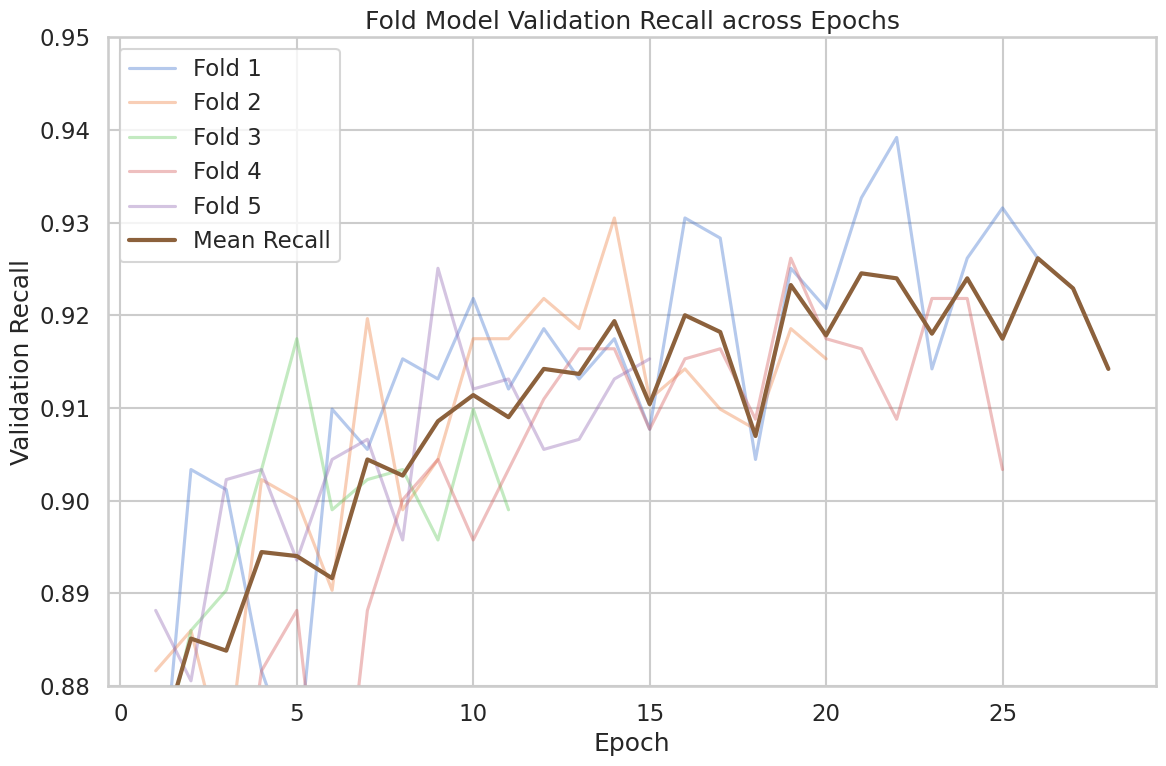

In [ ]:
# Open recall curves file in read-only mode
with open(recall_curve_path, 'rb') as rcp:

  # Set visualization theme
  sns.set_theme(style = 'whitegrid', context = 'talk', palette = 'muted')

  # Extract K-fold CV recall curves
  curves = pickle.load(rcp)

  # Create figure on which to plot recall curves
  plt.figure(figsize = (12, 8))

  # Iterate over all fold curves
  for fold, curve in enumerate(curves):

    # Create lineplot of fold model recall score curve
    sns.lineplot(x = range(1, len(curve) + 1), y = curve,
        label = f"Fold {fold + 1}",
        alpha = 0.4
    )

  # Find maximum length of curves, to account for early stopping
  max_length = max(len(curve) for curve in curves)

  # Compute mean fold model recall score curve, accounting for
  # null values in cases of early stopping
  mean_curve = np.nanmean(
      np.array([np.pad(curve, (0, max_length-len(curve)), constant_values=np.nan) for curve in curves]),
      axis=0
  )

  # Create lineplot of mean fold recall curve
  sns.lineplot(x = range(1, max_length + 1), y = mean_curve,
      label = "Mean Recall",
      linewidth = 3
  )

  # Set plot title and axis labels
  plt.title('Fold Model Validation Recall across Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Validation Recall')

  # Bound y-axis at minimum and maximum
  plt.ylim(0.88, 0.95)

  # Set plot layout
  plt.tight_layout()

  # Reveal plot
  plt.show()

As you can see, there's quite a lot of noise in our recall curves. Recall is generally a noisy metric, more sample-dependent than a metric like ROC-AUC, which tracks the probability that a randomly chosen positive is classified as more likely to be positive than a randomly chosen negative. This probabilistic nature smooths out ROC-AUC, while recall tends to vary heavily because it depends on the probability threshold to predict malignancy of our model, which can vary depending on how our data is split between training and validation sets.

Despite this noise, we can clearly see an upward trend in recall, both in each individual fold and in the average of all folds. This upward trend is rapid at first, then slows down as it approaches 0.93 towards the end, which tracks with the typical learning pattern of neural networks. This is precisely why we implemented early stopping, to avoid wasting resources on further training once our model achieves its limit of performance.

In [ ]:
# Notify user that model testing has begun
print("EVALUATING ON TEST SET")

# Configure test dataset path
test_zip = "/content/drive/MyDrive/DATA602_Final_Project/test_resized.zip"

# Define path to extract unzipped test set
unzipped_test = "/content/Unzipped_Test"

# Remove unzipped test destination file if
# already exists
if os.path.exists(unzipped_test):
    shutil.rmtree(unzipped_test)

# Open test dataset zipfile as read-only
with zipfile.ZipFile(test_zip, 'r') as zipped_test:

    # Extract unzipped test set to predefined path
    zipped_test.extractall(unzipped_test)

# Load test data with same data preparation pipeline as training
test_set = datasets.ImageFolder(root=unzipped_test, transform=data_prep)

# Create test DataLoader to serve batches of test data to our model
test_loader = DataLoader(test_set, batch_size=config['batch_size'],
                         shuffle=False, num_workers=2, pin_memory=True)

# Notify user of test set size
print(f"Test samples: {len(test_set)}\n")

EVALUATING ON TEST SET
Test samples: 1000



In [ ]:
# Create empty list to hold test recall scores
test_recalls = []

# Create empty list to hold test precision scores
test_precisions = []

# Create empty list to hold test F1 scores
test_f1s = []

# Create empty list to hold test ROC-AUC scores
test_aucs = []

# Create variable to hold best recall
best_recall = -1

# Create variable to hold best-performing fold number
best_fold = None

# Create list to hold false negatives
# of best-performing model
best_fn_list = []

# Iterate over all K-folds
for fold in range(config['k']):

    # Notify user of which fold we're evaluating
    print(f"Evaluating Fold {fold + 1} model:")

    # Create list to hold false negatives
    fn_list = []

    # Load best model from current fold
    model_path = f"{checkpoints_folder}/best_model_fold{fold}.pt"
    model.load_state_dict(torch.load(model_path))

    # Set model to evaluation mode
    model.eval()

    # Create list to hold predictions, true class labels,
    # and predicted probabilities
    test_preds, test_labels, test_probs = [], [], []

    # Turn off gradient tracking (loss computation)
    with torch.no_grad():

        # Iterate over all images in each batch
        for batch_i, (images, labels_batch) in enumerate(tqdm(test_loader, desc=f"Fold {fold+1} Test")):

            # Load images and class labels to device
            images = images.to(chip)
            labels_batch = labels_batch.float().unsqueeze(1).to(chip)

            # Predict class of images using model
            outputs = model(images)

            # Extract predicted class labels
            pred_labels = (outputs > 0.5).cpu().numpy().flatten()

            # Extract true class labels
            true_labels = labels_batch.cpu().numpy().flatten()

            # Add batch predictions to list
            test_preds.extend(pred_labels)

            # Add batch true labels to list
            test_labels.extend(true_labels)

            # Add batch predicted probabilities to list
            test_probs.extend(outputs.cpu().numpy().flatten())

            # Define batch starting index
            batch_start = batch_i * config['batch_size']

            # Iterate over all extracted labels
            for i, (t, p) in enumerate(zip(true_labels, pred_labels)):

                # If model prediction is false negative
                if t == 1 and p == 0:

                  # Append index to false negative list
                  fn_list.append(batch_start + i)

    # Compute test set recall score
    test_recall = recall_score(test_labels, test_preds, zero_division=0)

    # Compute test set precision score
    test_precision = precision_score(test_labels, test_preds, zero_division=0)

    # Compute test set F1 score
    test_f1 = f1_score(test_labels, test_preds, zero_division=0)

    # Compute test set ROC-AUC score
    test_auc = roc_auc_score(test_labels, test_probs) if len(set(test_labels)) > 1 else 0.0

    # Append test recall score to list
    test_recalls.append(test_recall)

    # Append test precision score to list
    test_precisions.append(test_precision)

    # Append test F1 score to list
    test_f1s.append(test_f1)

    # Append test ROC-AUC score to list
    test_aucs.append(test_auc)

    # Notify user of fold model test performance
    print(f"Fold {fold + 1} Test Results:\n")
    print(f"\nRecall: {test_recall:.4f} | Precision: {test_precision:.4f} | F1: {test_f1:.4f} | AUC: {test_auc:.4f}\n")

    # If first fold or test recall score is new best test recall score achieved
    if fold == 0 or test_recall > best_recall:

      # Store best test recall score achieved
      best_recall = test_recall

      # Store fold of best test recall score achieved
      best_fold = fold

      # Store false negative list of best-performing fold model
      best_fn_list = fn_list.copy()

Evaluating Fold 1 model:


Fold 1 Test: 100%|██████████| 63/63 [00:10<00:00,  6.29it/s]


Fold 1 Test Results:


Recall: 0.9080 | Precision: 0.9439 | F1: 0.9256 | AUC: 0.9768

Evaluating Fold 2 model:


Fold 2 Test: 100%|██████████| 63/63 [00:01<00:00, 50.07it/s]


Fold 2 Test Results:


Recall: 0.8920 | Precision: 0.9510 | F1: 0.9205 | AUC: 0.9763

Evaluating Fold 3 model:


Fold 3 Test: 100%|██████████| 63/63 [00:01<00:00, 48.38it/s]


Fold 3 Test Results:


Recall: 0.8920 | Precision: 0.9215 | F1: 0.9065 | AUC: 0.9688

Evaluating Fold 4 model:


Fold 4 Test: 100%|██████████| 63/63 [00:01<00:00, 50.44it/s]


Fold 4 Test Results:


Recall: 0.8940 | Precision: 0.9470 | F1: 0.9198 | AUC: 0.9769

Evaluating Fold 5 model:


Fold 5 Test: 100%|██████████| 63/63 [00:01<00:00, 50.27it/s]

Fold 5 Test Results:


Recall: 0.8860 | Precision: 0.9307 | F1: 0.9078 | AUC: 0.9722



In [ ]:
# Create list to hold filepaths of false negatives of best model
wrong_files = []

# Iterate over list of false negatives of best model
for index in best_fn_list:

    # Extract filepath and class index
    path, class_index = test_set.samples[index]

    # Extract class folder name using class index
    class_folder_name = test_set.classes[class_index]

    # Extract filename from path
    filename = os.path.basename(path)

    # Append class folder name and filename to list
    wrong_files.append([class_folder_name, filename])

# Convert false negative filepath list to DataFrame
wrong_df = pd.DataFrame(wrong_files, columns=["Class", "Filename"])

In [ ]:
# Aggregate mean test recall score
mean_test_recall = np.mean(test_recalls)

# Compute standard deviation of test recall score
std_test_recall = np.std(test_recalls)

# Compute confidence interval of test recall score
ci_test_recall = 1.96 * std_test_recall / np.sqrt(config['k'])

# Aggregate mean test precision score
mean_test_precision = np.mean(test_precisions)

# Aggregate mean test F1 score
mean_test_f1 = np.mean(test_f1s)

# Aggregate mean test ROC-AUC score
mean_test_auc = np.mean(test_aucs)

# Notify user of aggregated test results
print("FINAL TEST SET RESULTS\n")
print(f"\nMean Test Recall:    {mean_test_recall:.4f} ± {std_test_recall:.4f}")
print(f"\n95% CI (Recall):     [{mean_test_recall - ci_test_recall:.4f}, {mean_test_recall + ci_test_recall:.4f}]")
print(f"\n\nMean Test Precision: {mean_test_precision:.4f}")
print(f"\nMean Test F1:        {mean_test_f1:.4f}")
print(f"\nMean Test AUC:       {mean_test_auc:.4f}")
print(f"\n\nIndividual Folds:    {[f'{r:.4f}' for r in test_recalls]}")

FINAL TEST SET RESULTS


Mean Test Recall:    0.8944 ± 0.0073

95% CI (Recall):     [0.8880, 0.9008]


Mean Test Precision: 0.9388

Mean Test F1:        0.9160

Mean Test AUC:       0.9742


Individual Folds:    ['0.9080', '0.8920', '0.8920', '0.8940', '0.8860']


Here we have our best estimate of model generalization performance, test set metrics. The test set is both truly unseen by our model, so it better represents how our model is likely to perform on data from real world usage.

Our model architecture achieved a **mean recall of 89.44%** across the best model from each fold, a slight drop from our validation performance, most likely due to differences in data distribution between the test set and the training set. However, this is still an impressive result that makes our model a useful tool to support clinical decision-making in dermatology.

Additional test metrics include:

*   **93.88% Mean Precision** (strong performance): This represents the percentage of test data predicted positive that is truly positive.
*   **0.9742 Mean ROC-AUC** (strong performance): This represents the probability that a random positive in our test set will be classified as more likely positive than a randomly chosen negative.
*   **91.60% Mean F1 Score** (strong performance): This represents the harmonic mean of precision and recall.

Strong results across all these metrics, not merely on our key metric of recall, indicate our model architecture is balanced and well-equipped for the diverse use cases in melanoma classification that real-world users may have. Overall, these results validate our architecture and show our model merits consideration for real-world application.

In [ ]:
# Log aggregated test results to Weights & Biases
wandb.log({
    "test_mean_recall": mean_test_recall,
    "test_std_recall": std_test_recall,
    "test_ci_recall": ci_test_recall,
    "test_mean_precision": mean_test_precision,
    "test_mean_f1": mean_test_f1,
    "test_mean_auc": mean_test_auc
})

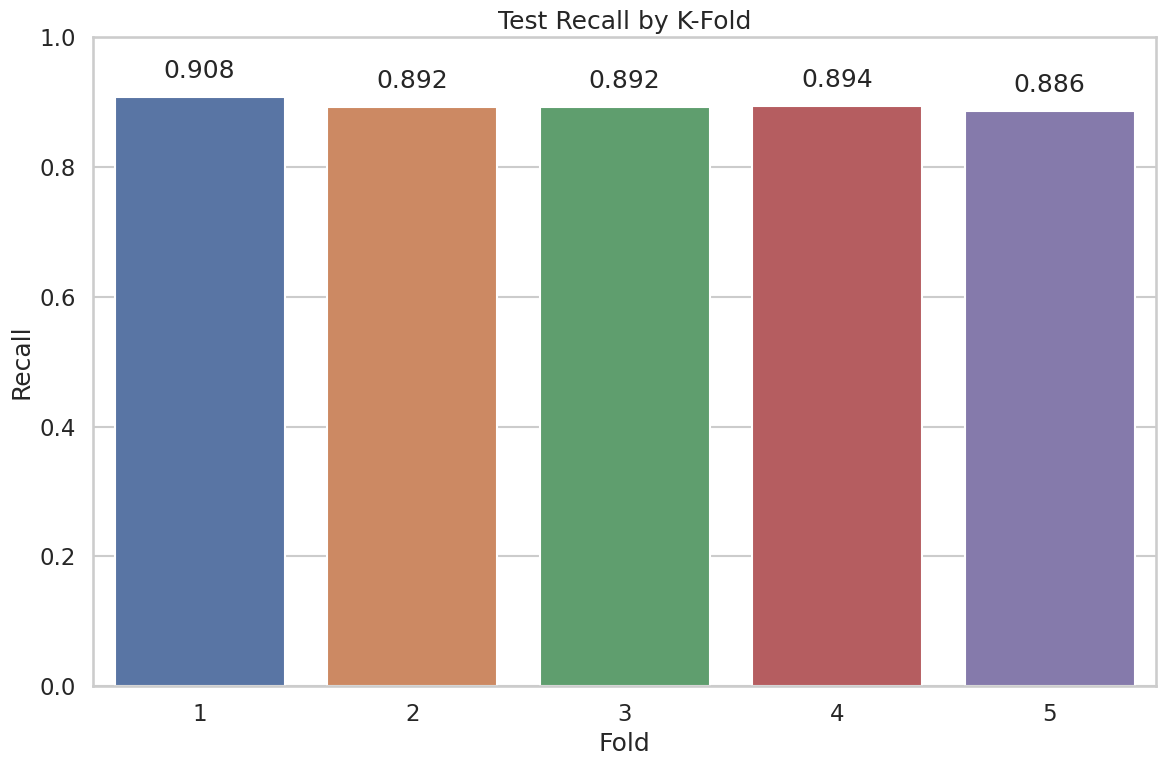

Evaluation complete! Check Weights & Biases for detailed results.


In [ ]:
# Set theme of plot of test recall
sns.set_theme(style='whitegrid', context='talk', palette='deep')

# Create figure on which to plot test recall
plt.figure(figsize = (12, 8))

# Create barplot on which to compare fold test recalls
sns.barplot(x = [f'{_ + 1}' for _ in range(config['k'])],
            y = test_recalls, hue = [f'{_ + 1}' for _ in range(config['k'])])

# Set plot title and axes
plt.title('Test Recall by K-Fold')
plt.xlabel('Fold')
plt.ylabel('Recall')

# Bound y-axis at maximum and minimum
plt.ylim(0,1)

# Iterate over all test recall scores
for i, recall in enumerate(test_recalls):

  # Include exact recall score on plot
  plt.text(i, recall + 0.03, f"{recall:.3f}", ha = 'center')

# Set plot layout
plt.tight_layout()

# Reveal plot
plt.show()

# Close our Weights & Biases session
wandb.finish()

# Notify user that evaluation is complete
print("Evaluation complete! Check Weights & Biases for detailed results.")

Here, we can see the tight spread of our fold models' test recall scores. The scores range from 0.886 at the lowest to 0.908 at the highest, which is a total range of only 2.2%. This tight spread is a testament to our model architecture's consistency and ability to achieve strong generalization on diverse training data (i.e., diverse augmented training-validation splits).

The small differences in model architecture performance that are present can be attributed to the stochastic nature of the AdamW optimization algorithm, as well as nuances in data augmentation and/or training-validation split.

Sample false negative images of best-performing model:


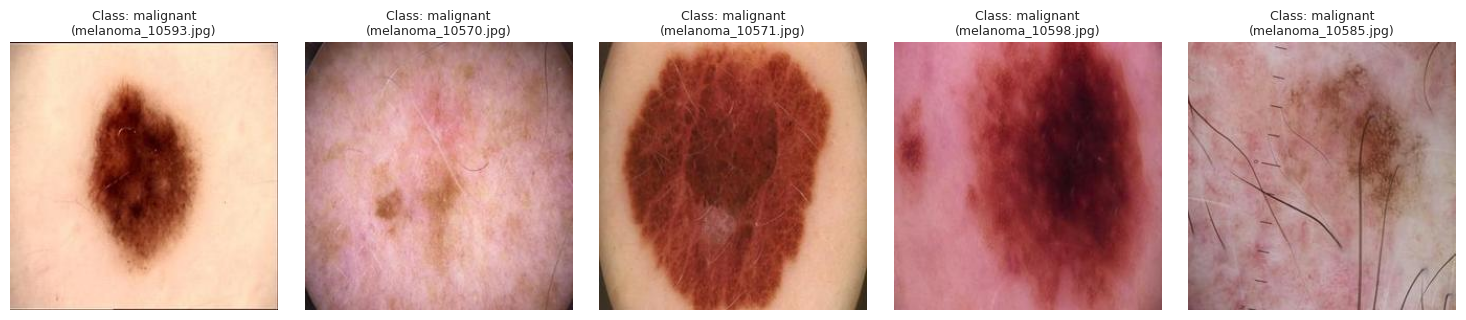

In [ ]:
# Notify user of what following images represent
print("Sample false negative images of best-performing model:")

# Display sample false negative images of best-performing model
display_sample_images(
    zip_path=test_zip,
    df=wrong_df,
    sample_size=min(5, len(wrong_df))
)

Here we can see some sample images that our model wrongly classified as negative. Since this is the outcome we most want to avoid, it's important to assess common characteristics of false negatives to see if we can better understand the limitations of our model.

From this initial eye test, we can see that our model misclassified two images with light brown lesions on a rosy skin background, and two very dark lesions. We can also observe that, interestingly, none of the false negative images displayed by our function are jittered or rotated images.

Whether this lack of augmentation or these image characteristics represent limitation(s) of our model will require further analysis to decide. Unfortunately, this analysis is outside the time scope of this project, but this is the natural next step of this project, which we intend to pursue in the future.

## Conclusion & Further Learning

We hope this tutorial has been useful to you! Thank you for following along with our work. We hope you see now that Machine Learning is not some indecipherable, inaccessible black box, but a technique that can be leveraged even by mere students to achieve great success in impactful work like clinical diagnosis.

There are certainly some spots we glazed over for brevity and readability's sake. If you enjoyed this tutorial and are wondering "what now?", we encourage you to dive deeper using the resources below!

To

To understand a main driver of the machine learning process, optimization algorithms, see this overview:

*   Srivastava, A., Rawat, B. S., Singh, G., Bhatnagar, V., Saini, P. K., & Shiv Ashish Dhondiyal. (2023). *A Review of Optimization Algorithms for Training Neural Networks.* https://doi.org/10.1109/icseiet58677.2023.10303287

To understand why we ultimately chose the AdamW optimizer after several iterations using the Adam optimizer:

*   Loshchilov, I., & Hutter, F. (2017). Decoupled Weight Decay Regularization. *Arxiv.org.* https://arxiv.org/abs/1711.05101



